# CP255 Final Project - 
# Relationship between Health, Urban Environs and Socioethnic Status
#### Cheng-Kai Hsu, PhD 2025, DCRP

In my final project, I aim to explore the relationship between health status, environment, transportation, socio-economic status, and ethnicity using global regression analysis, spatial autocorrelation analysis, geographically weighted regression (GWR) analysis, data visualization, and interactive mapping.

In the following lines, Part 0 introduces the modules and data employed in this project; Part 1 presents descriptive statistics, correlation analysis, and data visualization for variables of interests at state level (California); Part 2 presents a new dimension of variables concerning physical activity and reports the results of regression (both global and GWR) analysis at city level (San Francisco), as well as result interpretation and data visualization; finally, Part 3 demonstrates some applications with interactive mapping tools, such as OSMNX, Folium, and Mapbox, that could potentially help users recognize potential environmental exposure risk along their travel.

# PART 0:
## Module import, data source description

All the modules employed in this project are listed and imported below. All the data sources (including public data website and api) are also noted. The naming of dataframe for each type of data is also noted in the code in order for readers to refer to while reading this notebook.

In [1]:
# Import libraries
import numpy as np
import pandas as pd; import geopandas as gpd
import libpysal as ps

# visualization, basemap, interactive mapping
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from shapely.geometry import Point
import contextily as cx
import fiona
%matplotlib inline
import pydeck as pdk
import folium
import osmapi as osm
import osmnx as ox
from colorcet import fire


# For API
import requests
import json
import shapely
import pprint as pp


# pip install sodapy for downloading CalEnvScreen 3.0 data
from sodapy import Socrata


#For regression and GWR:
import statsmodels.api as sm
import numpy as np
from patsy import dmatrices
import esda as esda
import splot as splot
from splot.libpysal import plot_spatial_weights
from splot.esda import moran_scatterplot, plot_moran
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap



# ------- Data discription-------
# State-wide (CA): geographic, health status, environment and traffic, socio-economic status, ethnicity
# City-wide (SF): Physical activity (bike sharing, bike station, park, tree, sidewalk)

# Sources:
# https://oehha.ca.gov/calenviroscreen/report/calenviroscreen-30
# https://www2.census.gov/geo/tiger/GENZ2018/shp/
# https://data.sfgov.org/resource/7jbp-yzp3.json (bike sharing)
# https://opendata.arcgis.com/datasets/b8ad067022374acd966db3026ddab6fc_0.geojson (bike rack)
# https://data.sfgov.org/Transportation/Map-of-Sidewalk-Widths/ygcm-bt3x (sidewalk) 


# ------- (Geo)Dataframe naming-------
# State level:
# df1: CA geographic data
# df2: CalEnviroScreen 3,0 data, including health outcome (e.g. asthma), environs (e.g. traffic, PM2.5, O3),
# socio-eco status (e.g. popverty, ethnicity), etc
# df3: merge df1 and df2

# City level:
# df5: sidewalk
# df6: bike 
# df7: bike sharing

# PART 1: CA-level
## Data description, correlation analysis, visualzation

In this part, I loaded two CA-state-level datasets, described data characteristics through descriptive statistics, correlation analysis, and data visualization. 

In [2]:
# import geo data for CA and name it df1
df1 = gpd.read_file('data/cb_2018_06_tract_500k/cb_2018_06_tract_500k.shp')

In [3]:
# display first 3 columns of df1
df1.head(3)

STATEFP COUNTYFP TRACTCE              AFFGEOID        GEOID     NAME LSAD  \
0      06      009  000300  1400000US06009000300  06009000300        3   CT   
1      06      011  000300  1400000US06011000300  06011000300        3   CT   
2      06      013  303102  1400000US06013303102  06013303102  3031.02   CT   

       ALAND  AWATER                                           geometry  
0  457009794  394122  POLYGON ((-120.76399 38.21389, -120.76197 38.2...  
1  952744514  195376  POLYGON ((-122.50006 39.12232, -122.50022 39.1...  
2    6507019       0  POLYGON ((-121.72937 37.96884, -121.71409 37.9...

<AxesSubplot:>

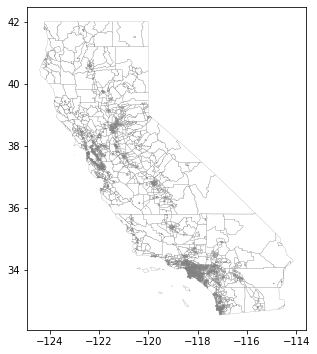

In [4]:
# plot the geo data
df1.plot(color='none', edgecolor='gray', linewidth=.2, figsize=(5,10))

In [5]:
# check the coordinate system
df1.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
# import CalEnvScreen 3.0 Data and name it df2, by following the instructions provided by the data source
# https://www.opendatanetwork.com/dataset/www.transparentrichmond.org/wi9v-3g3n
client = Socrata("www.transparentrichmond.org", None)

# Returned as JSON from API 
results = client.get("wi9v-3g3n", limit=20000)

# Convert to pandas DataFrame
df2 = pd.DataFrame.from_records(results)


In [7]:
# display data, including health outcome (e.g. asthma), environs (e.g. traffic, PM2.5, O3, diesel PM),
# socioethnic status (e.g. popverty, education level, ethnicity)
df2.head(2)

the_geom         tract pop2010  \
0  {'type': 'MultiPolygon', 'coordinates': [[[[-1...  6083002103.0    3930   
1  {'type': 'MultiPolygon', 'coordinates': [[[[-1...  6083002402.0   11406   

      california    zip         city     longitude    latitude ciscore  \
0  Santa Barbara  93454  Santa Maria  -120.4270588  34.9306689   29.51   
1  Santa Barbara  93455  Santa Maria  -120.4780833  34.9287963   33.17   

  ciscorep  ... african_am native_ame asian_amer other_pct objectid_1  \
0       59  ...        1.9        0.5        7.2       1.6       3507   
1       65  ...        1.4        0.2        5.5       1.6       2733   

  cidecile civigintil     shape_leng     shape_area ces2018_rn  
0        6         12  6999.35762193  2847611.28417     55-60%  
1        7         14  19100.5780032  16352920.1391     65-70%  

[2 rows x 71 columns]

In [8]:
# display all the columns (i.e. variables)
df2.columns

Index(['the_geom', 'tract', 'pop2010', 'california', 'zip', 'city',
       'longitude', 'latitude', 'ciscore', 'ciscorep', 'ozone', 'ozonep', 'pm',
       'pmp', 'diesel', 'dieselp', 'drink', 'drinkp', 'pest', 'pestp',
       'rseihaz', 'rseihazp', 'traffic', 'trafficp', 'cleanups', 'cleanupsp',
       'gwthreats', 'gwthreatsp', 'haz', 'hazp', 'iwb', 'iwbp', 'swis',
       'swisp', 'pollution', 'pollutions', 'pollutionp', 'asthma', 'asthmap',
       'lbw', 'lbwp', 'cvd', 'cvdp', 'edu', 'edup', 'ling', 'lingp', 'pov',
       'povp', 'unemp', 'unempp', 'housingb', 'housingbp', 'popchar',
       'popcharsco', 'popcharp', 'children_u', 'pop_11_64_', 'elderly_ov',
       'hispanic_p', 'white_pct', 'african_am', 'native_ame', 'asian_amer',
       'other_pct', 'objectid_1', 'cidecile', 'civigintil', 'shape_leng',
       'shape_area', 'ces2018_rn'],
      dtype='object')

The variables of interest to this project include geographic data ('tract' and 'zip') as well as, those variables within four main dimensions, health status ('asthma','lbw','cvd'), environment and traffic ('traffic','diesel,'pm'), socio-economic status ('edu','ling','pov') and ethnicity ('white_pct','african_am', 'asian_amer'). For each variable employed in this project, the description is listed as follows:

'zip':Postal ZIP Code that the census tract falls within

'asthma': Age-adjusted rate of emergency department visits for asthma.

'lbw': Percent low birth weight

'cvd': Percent low birth weight

'traffic': Traffic density, in vehicle-kilometers per hour per road length, within 150 meters of the census tract boundary

'diesel': Diesel PM emissions from on-road and non-road sources

'pm': Annual mean PM 2.5 concentrations

'edu': Percent of population over 25 with less than a high school education

'ling': Percent limited English speaking households

'pov': Percent of population living below two times the federal poverty level

'white_pct': Percent of white households

'african_am': Percent of african households

'asian_amer': Percent of asian households


The description for other variables can be found via the link: https://oehha.ca.gov/calenviroscreen/report/calenviroscreen-30.

In [9]:
# Extract variables of interest
df2=df2[['tract','zip','pm','traffic', 'diesel','asthma','lbw','cvd','edu','ling','pov','white_pct','african_am','asian_amer']]

In [10]:
# (see the following two lines)
# Found two already imported dataset use different naming of polygon identification 

In [11]:
df1.GEOID[:5]

0    06009000300
1    06011000300
2    06013303102
3    06013303202
4    06013303203
Name: GEOID, dtype: object

In [12]:
df2.tract[:5]

0    6083002103.0
1    6083002402.0
2    6083002102.0
3    6083002010.0
4    6083002009.0
Name: tract, dtype: object

In [13]:
# For df2, remove the last two character (e.g. ".0") in the string
for i in range(len(df2['tract'])):
    if df2['tract'].iloc[i].find('.') != -1:
        df2['tract'].iloc[i] = df2['tract'].iloc[i][:-2]
        
df2['tract'][:5]

0    6083002103
1    6083002402
2    6083002102
3    6083002010
4    6083002009
Name: tract, dtype: object

In [14]:
# For df1, remove the first character (i.e. "0")
df1.GEOID=df1.GEOID.map(lambda x: x[1:])
df1['GEOID'][:5]

0    6009000300
1    6011000300
2    6013303102
3    6013303202
4    6013303203
Name: GEOID, dtype: object

In [15]:
# merge the aforementioned two dataset (i.e. df1 and df2) as a new dataframe called df3
df3=pd.merge(df1, df2, left_on='GEOID', right_on='tract')
df3.head(2)

STATEFP COUNTYFP TRACTCE              AFFGEOID       GEOID NAME LSAD  \
0      06      009  000300  1400000US06009000300  6009000300    3   CT   
1      06      011  000300  1400000US06011000300  6011000300    3   CT   

       ALAND  AWATER                                           geometry  ...  \
0  457009794  394122  POLYGON ((-120.76399 38.21389, -120.76197 38.2...  ...   
1  952744514  195376  POLYGON ((-122.50006 39.12232, -122.50022 39.1...  ...   

  diesel asthma   lbw   cvd   edu  ling   pov white_pct african_am asian_amer  
0   0.26  58.33  4.04  7.49   8.4   0.7  28.0      83.9        1.1        1.1  
1   1.53  30.94  4.83  9.47  41.5  12.5  39.8      26.6        0.9        2.0  

[2 rows x 24 columns]

In [16]:
# (See the following two lines)
# make some thematic maps with columns 'traffic density' and 'households living with poverty'

<AxesSubplot:>

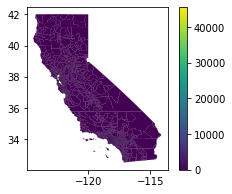

In [17]:
df3["traffic"] = pd.to_numeric(df3["traffic"], downcast="float")

base = df3.plot(color='none', edgecolor='gray', linewidth=.2, figsize=(4,3))
df3.plot(ax=base, column='traffic',legend=True)

# The result is a bit odd, which would be solved afterwards

<AxesSubplot:>

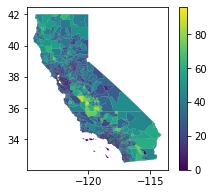

In [18]:
df3["pov"] = pd.to_numeric(df3["pov"], downcast="float")

base = df3.plot(color='none', edgecolor='gray', linewidth=.2, figsize=(4,3))
df3.plot(ax=base, column='pov',legend=True)

# The result makes sense and I make a map for each variable in the next line of code and provide some descriptions.

### CA-level Chloropleth Maps
From the 12 chloropleth maps shown above, we can see that there are some distinct, through quite expected, spatial patterns.

For health status, it can be observed a lighter, yellow and orange spots in the middle belt of the CA state. This spatial pattern highly corresponds to the data for the ethnic dimension; along that belt, there are less white households but more african and asian households can be found. 

For the other two dimensions (i.e. socioecnomic and envrionment), we can see that people living along this belt tend to be less affluent, less educated, facing more language barriers, exposed to higher pm2.5. However, it is less clear on the distribution of traffic density and diesel particulate matters as both of these data could be likely too concentrated and not dispersed enough to observe a explicit spatial pattern, which might be due to some outliers that pull up the range of legend.

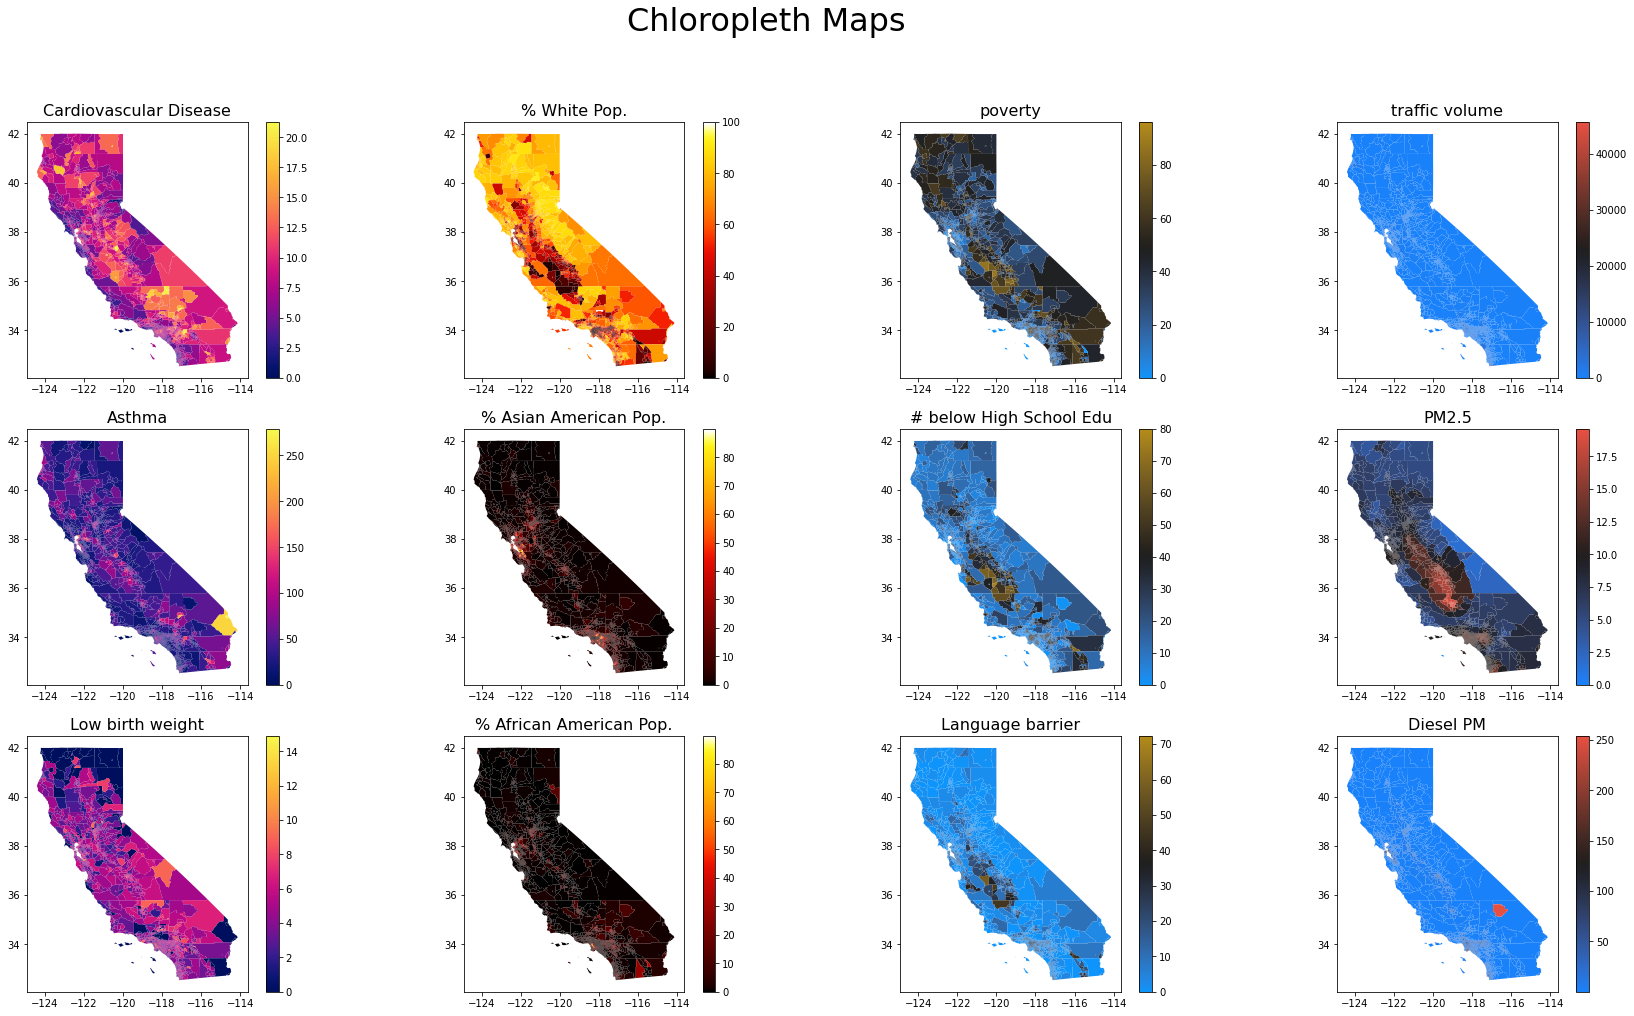

In [23]:
# Plot all variables with chloropleth maps for 12 variables within the four dimensions 
# (i.e. health, socioeconomic, ethnicity, environs)
# cannot see a clear pattern of traffic density 

f,(ax1,ax2,ax3) = plt.subplots(3,4,figsize=(30,16))
f.suptitle("Chloropleth Maps", fontsize=32)

    # Health
df3["cvd"] = pd.to_numeric(df3["cvd"], downcast="float")
df3["lbw"] = pd.to_numeric(df3["lbw"], downcast="float")
df3["asthma"] = pd.to_numeric(df3["asthma"], downcast="float")

    # Socio-economic
df3["pov"] = pd.to_numeric(df3["pov"], downcast="float")
df3["edu"] = pd.to_numeric(df3["edu"], downcast="float")
df3["ling"] = pd.to_numeric(df3["ling"], downcast="float")

    # Ethnicity
df3["white_pct"] = pd.to_numeric(df3["white_pct"], downcast="float")
df3["asian_amer"] = pd.to_numeric(df3["asian_amer"], downcast="float")
df3["african_am"] = pd.to_numeric(df3["african_am"], downcast="float")

    # Environs
df3["traffic"] = pd.to_numeric(df3["traffic"], downcast="float")
df3["pm"] = pd.to_numeric(df3["pm"], downcast="float")
df3["diesel"] = pd.to_numeric(df3["diesel"], downcast="float")


df3.plot(ax=ax1[0], column='cvd',legend=True, cmap="cet_CET_L8")
ax1[0].set_title("Cardiovascular Disease", fontsize=16)

df3.plot(ax=ax2[0], column='asthma',legend=True, cmap="cet_CET_L8")
ax2[0].set_title("Asthma", fontsize=16)

df3.plot(ax=ax3[0], column='lbw',legend=True, cmap="cet_CET_L8")
ax3[0].set_title("Low birth weight", fontsize=16)



df3.plot(ax=ax1[1], column='white_pct',legend=True, cmap='cet_fire')
ax1[1].set_title("% White Pop.", fontsize=16)

df3.plot(ax=ax2[1], column='asian_amer',legend=True, cmap='cet_fire')
ax2[1].set_title("% Asian American Pop.", fontsize=16)

df3.plot(ax=ax3[1], column='african_am',legend=True, cmap='cet_fire')
ax3[1].set_title("% African American Pop.", fontsize=16)



df3.plot(ax=ax1[2], column='pov',legend=True, cmap='cet_CET_D6')
ax1[2].set_title("poverty", fontsize=16)

df3.plot(ax=ax2[2], column='edu',legend=True, cmap='cet_CET_D6')
ax2[2].set_title("# below High School Edu", fontsize=16)

df3.plot(ax=ax3[2], column='ling',legend=True, cmap='cet_CET_D6')
ax3[2].set_title("Language barrier", fontsize=16)



df3.plot(ax=ax1[3], column='traffic',legend=True,cmap='cet_CET_D4')
ax1[3].set_title("traffic volume", fontsize=16)

df3.plot(ax=ax2[3], column='pm',legend=True, cmap='cet_CET_D4')
ax2[3].set_title("PM2.5", fontsize=16)

df3.plot(ax=ax3[3], column='diesel',legend=True, cmap='cet_CET_D4')
ax3[3].set_title("Diesel PM", fontsize=16);

### Descriptive statistics (box plots and histograms)
Using both box plots and histograms, we can see the discriptive statistics of all variables of interest and found that potential outliers exist in the variable of traffic density. I also can be observed that there are ethnic segregations among census tracts as, in some tracts, African and Asian households are the dominant ethnicities. Compared with the chloropleth maps, these spatial patterns could potentially correlate with poor socioeconomic status. 

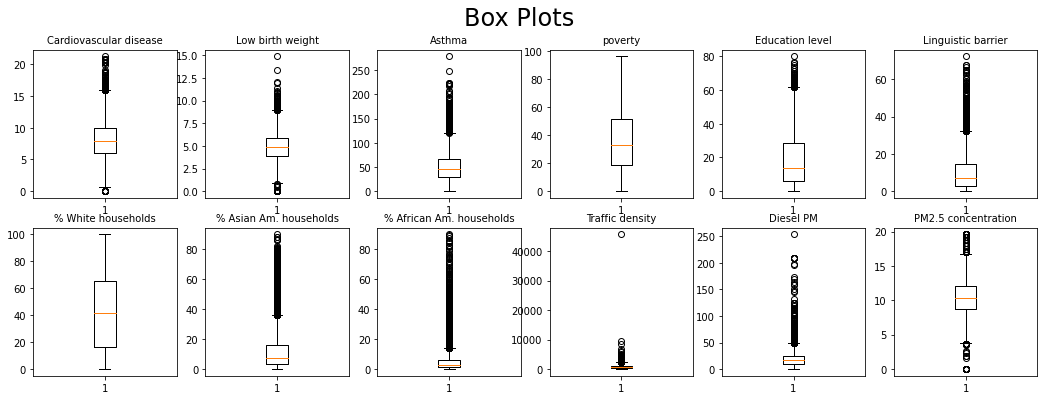

In [24]:
f=plt.figure(figsize=(18, 6))
f.suptitle("Box Plots", fontsize=24)

plt.subplot(261)
plt.boxplot(df3.cvd)
plt.title('Cardiovascular disease', fontsize=10)

plt.subplot(262)
plt.boxplot(df3.lbw)
plt.title('Low birth weight', fontsize=10)

plt.subplot(263)
plt.boxplot(df3.asthma)
plt.title('Asthma', fontsize=10)

plt.subplot(264)
plt.boxplot(df3.pov)
plt.title('poverty', fontsize=10)

plt.subplot(265)
plt.boxplot(df3.edu)
plt.title('Education level', fontsize=10)

plt.subplot(266)
plt.boxplot(df3.ling)
plt.title('Linguistic barrier', fontsize=10)

plt.subplot(267)
plt.boxplot(df3.white_pct)
plt.title('% White households', fontsize=10)

plt.subplot(268)
plt.boxplot(df3.asian_amer)
plt.title('% Asian Am. households', fontsize=10)

plt.subplot(269)
plt.boxplot(df3.african_am)
plt.title('% African Am. households', fontsize=10)

plt.subplot(2,6,10)
plt.boxplot(df3.traffic)
plt.title('Traffic density', fontsize=10)

plt.subplot(2,6,11)
plt.boxplot(df3.diesel)
plt.title('Diesel PM', fontsize=10)

plt.subplot(2,6,12)
plt.boxplot(df3.pm)
plt.title('PM2.5 concentration', fontsize=10);


In [28]:
df3['traffic'].describe()

count     8034.000000
mean       936.348999
std        907.578857
min          0.000000
25%        437.057495
50%        695.369995
75%       1184.949982
max      45687.871094
Name: traffic, dtype: float64

In [29]:
# remove the outliers in 'traffic density'
low=df3['traffic'].quantile(.01)
high=df3['traffic'].quantile(.99)
high

3672.8413183593752

In [30]:
df3_f = df3[(df3['traffic'] < high) & (df3['traffic'] > low)]
df3_f['traffic'].describe()

count    7872.000000
mean      905.971558
std       672.920044
min        64.830002
25%       441.995003
50%       695.369995
75%      1170.357452
max      3671.219971
Name: traffic, dtype: float64

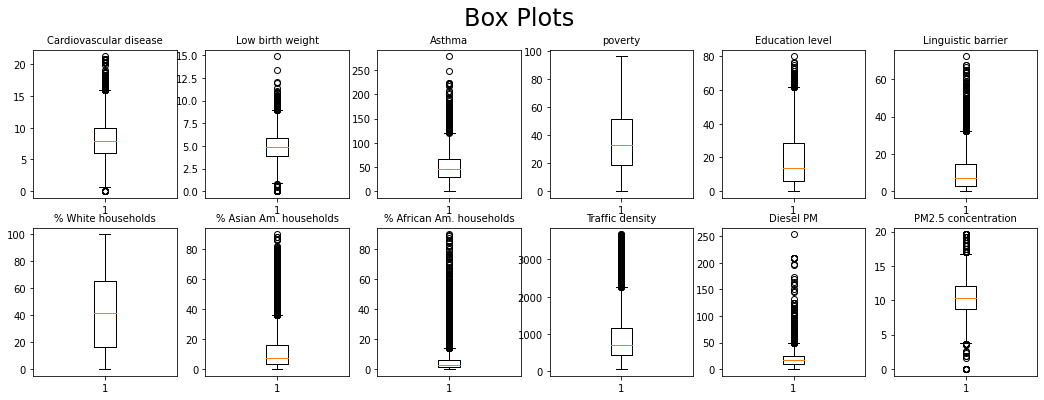

In [31]:
f=plt.figure(figsize=(18, 6))
f.suptitle("Box Plots", fontsize=24)

plt.subplot(261)
plt.boxplot(df3.cvd)
plt.title('Cardiovascular disease', fontsize=10)

plt.subplot(262)
plt.boxplot(df3.lbw)
plt.title('Low birth weight', fontsize=10)

plt.subplot(263)
plt.boxplot(df3.asthma)
plt.title('Asthma', fontsize=10)

plt.subplot(264)
plt.boxplot(df3.pov)
plt.title('poverty', fontsize=10)

plt.subplot(265)
plt.boxplot(df3.edu)
plt.title('Education level', fontsize=10)

plt.subplot(266)
plt.boxplot(df3.ling)
plt.title('Linguistic barrier', fontsize=10)

plt.subplot(267)
plt.boxplot(df3.white_pct)
plt.title('% White households', fontsize=10)

plt.subplot(268)
plt.boxplot(df3.asian_amer)
plt.title('% Asian Am. households', fontsize=10)

plt.subplot(269)
plt.boxplot(df3.african_am)
plt.title('% African Am. households', fontsize=10)

plt.subplot(2,6,10)
plt.boxplot(df3_f.traffic)
plt.title('Traffic density', fontsize=10)

plt.subplot(2,6,11)
plt.boxplot(df3.diesel)
plt.title('Diesel PM', fontsize=10)

plt.subplot(2,6,12)
plt.boxplot(df3.pm)
plt.title('PM2.5 concentration', fontsize=10);

plt.show();



''

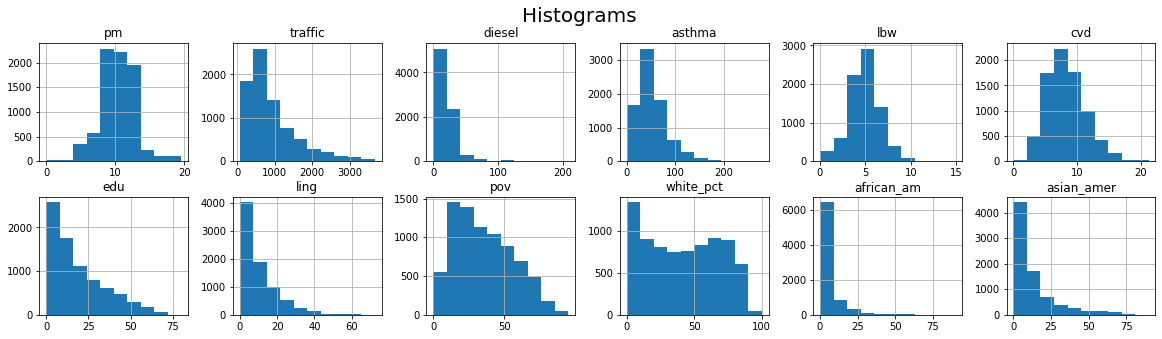

In [37]:
# another way for descriptive statistics, i.e. histograms for observing data distribution  

fig, ax = plt.subplots(2, 6,figsize=(20,5))
fig.suptitle("Histograms", fontsize=20)

m=12
# starting from 'pm' that is indexed as 12
for i in range(2):
    for j in range(6):
        df3_f.hist(column = df3_f.columns[m], ax=ax[i,j], figsize=(20, 18))
        m+=1

;

In [38]:
# We have three geo-levels, i.e. tract, zip, city (SF).
# For data reduction, I used the groupby operation to produce mean values of some variables for every zip code
df3_1=df3_f.groupby(df3_f['zip']).mean()
df3_1.head()

ALAND      AWATER    pm     traffic  diesel     asthma   lbw  \
zip                                                                        
32   3.003961e+09  20663794.0  6.32  117.139999    0.13  27.590000  3.12   
35   3.191027e+09   7990907.0  4.88   87.540001    0.12  30.620001  0.00   
40   2.163200e+09  35550930.0  5.26  106.870003    0.09  39.930000  6.73   
48   1.193827e+09  10910635.0  3.63   76.430000    0.35  34.770000  3.59   
51   1.219176e+09  26378126.0  6.28  154.729996    0.20  31.760000  3.50   

       cvd   edu  ling        pov  white_pct  african_am  asian_amer  
zip                                                                   
32    5.72  26.0  12.1  45.500000  52.599998         0.6         0.6  
35   10.97   8.4   0.5  39.099998  89.400002         0.6         0.4  
40   11.68  10.3   0.0  35.500000  88.000000         0.4         1.0  
48    7.17  21.0   0.8  56.000000  73.800003         1.0         0.7  
51    6.55   5.4   0.0  31.000000  87.900002         0.2         0.7

In [39]:
len(df3)

8034

In [40]:
# Reduce data from 8034 to 1334 rows
len(df3_1)

1334

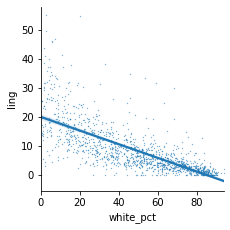

In [41]:
# white people has low lingustic barrier, as expected
lm=sns.lmplot("white_pct", "ling", data=df3_1, fit_reg=True, scatter=True, scatter_kws={"s": .1})
lm.fig.set_figwidth(3)
lm.fig.set_figheight(3)

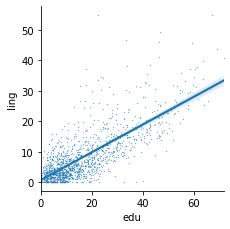

In [42]:
# lower educational level positively correlate with low lingustic barrier, as expected
lm=sns.lmplot("edu", "ling", data=df3_1,scatter_kws={"s": .1})
lm.fig.set_figwidth(3)
lm.fig.set_figheight(3)

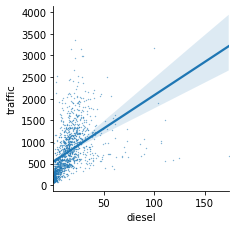

In [43]:
# diesel PM positively correlate with traffic that is one of the main sources of the diesel PM
lm=sns.lmplot("diesel", "traffic", data=df3_1,scatter_kws={"s": .1})
lm.fig.set_figwidth(3)
lm.fig.set_figheight(3)

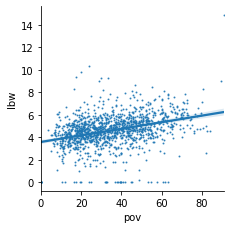

In [44]:
# less affluent households tend to have health issue concerning low birth weight
lm=sns.lmplot("pov", "lbw", data=df3_1,scatter_kws={"s": 1})
lm.fig.set_figwidth(3)
lm.fig.set_figheight(3)

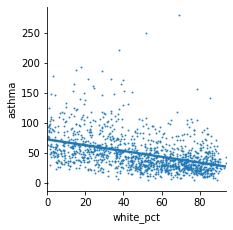

In [45]:
# places with more white households tend not to have asthmatic issue
lm=sns.lmplot("white_pct", "asthma", data=df3_1,scatter_kws={"s": 1})
lm.fig.set_figwidth(3)
lm.fig.set_figheight(3)

### CA-level correlation analysis results
Instead of making more scatter plots, I perform pair-wise correlation analyses. 
The correlation analysis shows that, for dimensions of health, environs, and socio-eco status, each variable is positively correlated with each other within the same dimension. And in the ethnic dimension, % white households is negatively correlated with the other two ethnic households. These collinearities should be noted when conducting regression analyses later (e.g. by choosing one variable as representative for each dimension). Also, all the factors in the socioeconomic dimension positively correlate with all the factors in the health dimensions (which can be seen more clearly from the second correlation analysis result).


Some other main findings: 

1) the factor, "% of white households", negatively correlate with all other variables. 

2) the factor, "% of african households", positively correlate with all other variables, except for "% of white households" (R=-.42).

3) the factor, "pm", postively correlate with all other variables, except for "% of white households" (R=-.47).

4) the factor, "diesel", similar to "pm", positively correlate with all other variables except for "% of white households" (R=-.39) and "cvd" (R=-.07, which however is very insignificant).

5) the variable, "diesel pm", correlates to "asthma" more than "pm" does, which have been proved by literature. But both correlation efficients are low (below 0.2), which can be explained by the fact that these two pollution indicators are collected on a yearly basis, i.e. some PM peak hours would be "diluted".


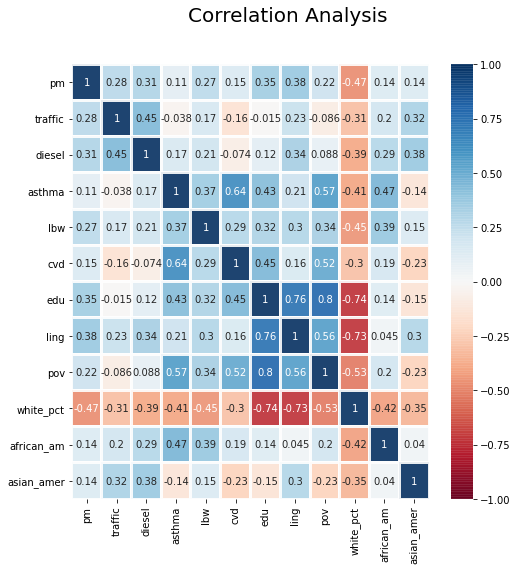

In [46]:
dfData = df3_1.iloc[:,2:].corr()
plt.subplots(figsize=(8, 8)) 
sns.heatmap(dfData, annot=True,vmax=1, vmin=-1, square=False, cmap="RdBu", alpha=.9, linewidths=2, linecolor='white', cbar=True)
plt.suptitle('Correlation Analysis', fontsize=20);

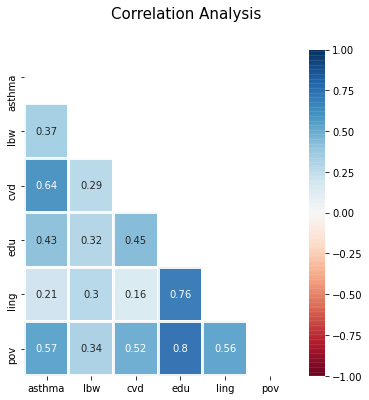

In [47]:
dfData = df3_1.iloc[:,5:11].corr()
plt.subplots(figsize=(6, 6)) 
mask = np.zeros_like(dfData)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dfData, annot=True,vmax=1, vmin=-1,mask=mask, square=False, cmap="RdBu", alpha=.9, linewidths=2, linecolor='white', cbar=True)
plt.suptitle('Correlation Analysis', fontsize=15);

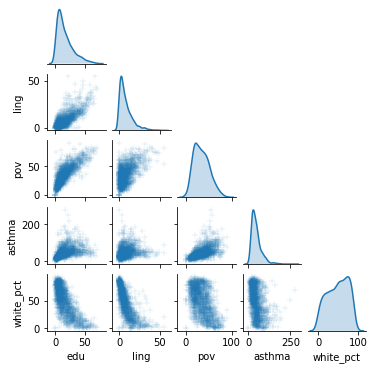

In [48]:
# tracts with more white households tend not to bear social and health burdens
sns.pairplot(df3_1,vars=["edu","ling","pov",'asthma',"white_pct"],height=1,diag_kind="kde",corner=True,plot_kws=dict(marker="+", linewidth=.1))

# PART 2: SF-level 
## Global regression, GWR, result mapping

Due to the limitation of computation ability of the computer used for this project, I narrow down the research scope to city-level, i.e. San Francisco, but broaden the variables by adding one more dimension to represent physical activity that have been proved benefitial for human health. The main dataframe used in the analysis are called 'SF' hereafter.

In [49]:
# Extract data with the label '075' in the column 'COUNTYFP' and display the first two rows.
SF = df3[df3['COUNTYFP']=='075']
SF.head(2)

STATEFP COUNTYFP TRACTCE              AFFGEOID       GEOID NAME LSAD  \
526      06      075  010200  1400000US06075010200  6075010200  102   CT   
527      06      075  011200  1400000US06075011200  6075011200  112   CT   

      ALAND  AWATER                                           geometry  ...  \
526  515958  295388  POLYGON ((-122.42667 37.80964, -122.42488 37.8...  ...   
527  177414       0  POLYGON ((-122.41629 37.79389, -122.41522 37.7...  ...   

         diesel     asthma   lbw   cvd   edu  ling   pov  white_pct  \
526   73.970001  43.160000  4.42  4.39   1.6   1.1  12.1  81.099998   
527  111.129997  27.790001  5.13  3.71  10.6  13.1  26.0  55.099998   

     african_am  asian_amer  
526         0.6   10.200000  
527         1.5   35.099998  

[2 rows x 24 columns]

In [50]:
# There are 195 data points left.
len(SF)

195

<AxesSubplot:>

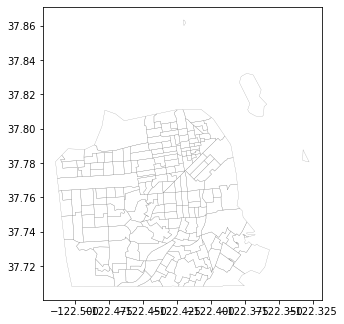

In [51]:
# Plot the geodataframe SF
SF.plot(color='none', edgecolor='gray', linewidth=.2, figsize=(5,10))

In [52]:
# Make box plots again to make sure no erroneous result
# No outliers found

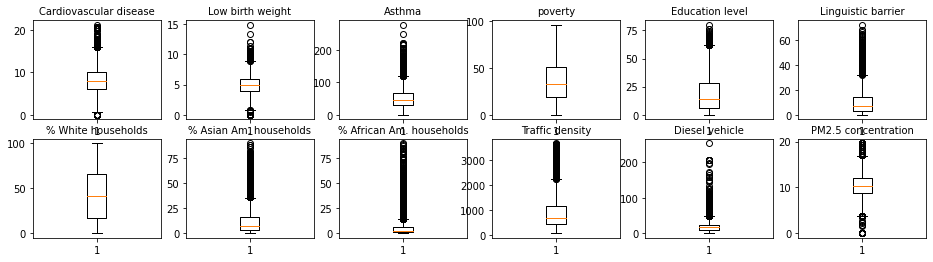

In [53]:
plt.figure(figsize=(16, 4))

plt.subplot(261)
plt.boxplot(df3.cvd)
plt.title('Cardiovascular disease', fontsize=10)

plt.subplot(262)
plt.boxplot(df3.lbw)
plt.title('Low birth weight', fontsize=10)

plt.subplot(263)
plt.boxplot(df3.asthma)
plt.title('Asthma', fontsize=10)

plt.subplot(264)
plt.boxplot(df3.pov)
plt.title('poverty', fontsize=10)

plt.subplot(265)
plt.boxplot(df3.edu)
plt.title('Education level', fontsize=10)

plt.subplot(266)
plt.boxplot(df3.ling)
plt.title('Linguistic barrier', fontsize=10)

plt.subplot(267)
plt.boxplot(df3.white_pct)
plt.title('% White households', fontsize=10)

plt.subplot(268)
plt.boxplot(df3.asian_amer)
plt.title('% Asian Am. households', fontsize=10)

plt.subplot(269)
plt.boxplot(df3.african_am)
plt.title('% African Am. households', fontsize=10)

plt.subplot(2,6,10)
plt.boxplot(df3_f.traffic)
plt.title('Traffic density', fontsize=10)

plt.subplot(2,6,11)
plt.boxplot(df3.diesel)
plt.title('Diesel vehicle', fontsize=10)

plt.subplot(2,6,12)
plt.boxplot(df3.pm)
plt.title('PM2.5 concentration', fontsize=10);


### SF-level correlation analysis results
Below, I make two correlation analyses again to make sure the correlations observed at state level also remain at the SF city level.

Most of the patterns found in the correlation analysis for the state-level remain. One new change is that Asian-White segregation becomes severer (the "absolute R value" increase from .35 to .71). 

Further, as can be seen in the second correlation analysis, socioeconomic status and ethnicity are more highly correlated:
i) White pop have higher education level, lower linguistic barrier, and lower poverty rate
ii) Asian pop have lower education level and high linguistic barrier
iii) African pop have high poverty rate
iv) they tend not to live close (all correlations are negative).

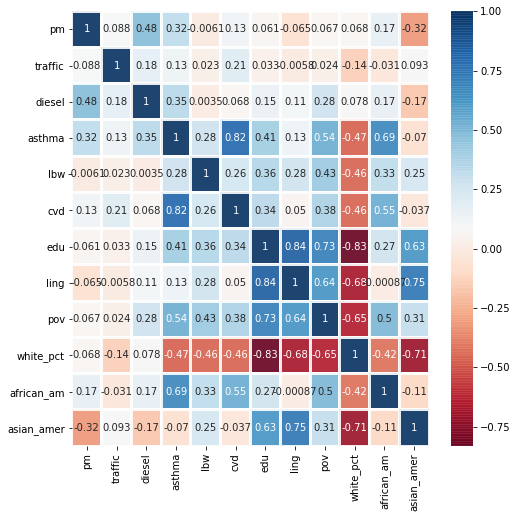

In [54]:
dfData = SF[['pm','traffic','diesel','asthma','lbw','cvd','edu','ling','pov','white_pct','african_am','asian_amer']].corr()
plt.subplots(figsize=(8,8)) 

sns.heatmap(dfData, annot=True, vmax=1, square=False, cmap="RdBu", alpha=.9, linewidths=2, linecolor='white', cbar=True)
plt.show()


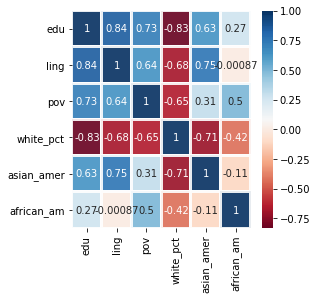

In [55]:
dfData = SF[['edu','ling','pov','white_pct','asian_amer','african_am']].corr()
plt.subplots(figsize=(4, 4)) 

sns.heatmap(dfData, annot=True, vmax=1, square=False, cmap="RdBu", alpha=.9, linewidths=2, linecolor='white', cbar=True)
plt.show()


### SF-level Chloropleth maps
For the health status dimension, the asthma have a clearer pattern to be observed and the pattern, similar to the previous in the state level, follow other factors in socioeconomic and ethnic dimensions. The most obvious pattern could be that there are two "lighter" spots for the factor "african_am", which correspond to the "lighter" spots for asthma. Further, these lighter spots are, in the map for factor "white_pct" are darker spots. 

Also, it can be seen that the range of factor "pm2.5" is very limited (from 7 to 9), which is quite low compared to the whole state (i.e. SF is cleaner), and thus might not be a good predictor for health issues.

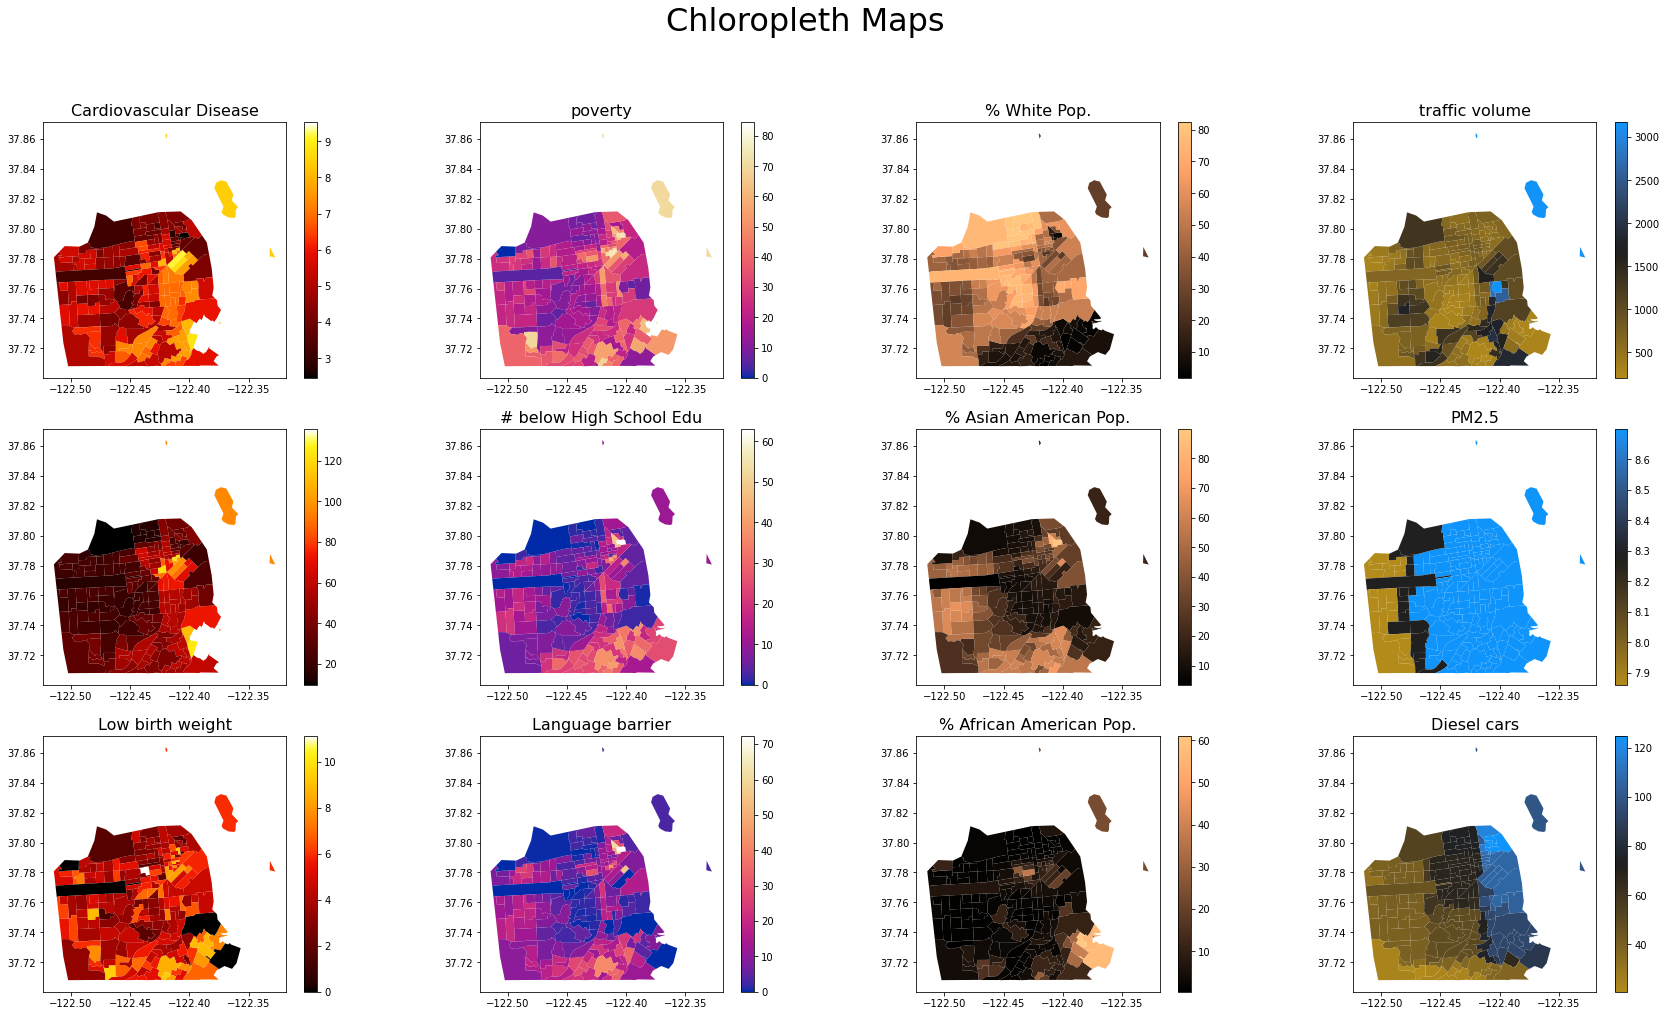

In [60]:
f,(ax1,ax2,ax3) = plt.subplots(3,4,figsize=(30,16))
f.suptitle("Chloropleth Maps", fontsize=32)

# # Health
# SF["cvd"] = pd.to_numeric(SF["cvd"], downcast="float")
# SF["lbw"] = pd.to_numeric(SF["lbw"], downcast="float")
# SF["asthma"] = pd.to_numeric(SF["asthma"], downcast="float")

# # Socio-economic
# SF["pov"] = pd.to_numeric(SF["pov"], downcast="float")
# df3["edu"] = pd.to_numeric(SF["edu"], downcast="float")
# df3["ling"] = pd.to_numeric(SF["ling"], downcast="float")

# # Ethnicity
# df3["white_pct"] = pd.to_numeric(df3["white_pct"], downcast="float")
# df3["asian_amer"] = pd.to_numeric(df3["asian_amer"], downcast="float")
# df3["african_am"] = pd.to_numeric(df3["african_am"], downcast="float")

# # Environs
# df3["traffic"] = pd.to_numeric(df3["traffic"], downcast="float")
# df3["pm"] = pd.to_numeric(df3["pm"], downcast="float")
# df3["diesel"] = pd.to_numeric(df3["diesel"], downcast="float")


SF.plot(ax=ax1[0], column='cvd',legend=True, cmap="cet_fire")
ax1[0].set_title("Cardiovascular Disease", fontsize=16)

SF.plot(ax=ax2[0], column='asthma',legend=True, cmap="cet_fire")
ax2[0].set_title("Asthma", fontsize=16)

SF.plot(ax=ax3[0], column='lbw',legend=True, cmap="cet_fire")
ax3[0].set_title("Low birth weight", fontsize=16)



SF.plot(ax=ax1[1], column='pov',legend=True, cmap='cet_CET_L17_r')
ax1[1].set_title("poverty", fontsize=16)

SF.plot(ax=ax2[1], column='edu',legend=True, cmap='cet_CET_L17_r')
ax2[1].set_title("# below High School Edu", fontsize=16)

SF.plot(ax=ax3[1], column='ling',legend=True, cmap='cet_CET_L17_r')
ax3[1].set_title("Language barrier", fontsize=16)



SF.plot(ax=ax1[2], column='white_pct',legend=True, cmap='copper')
ax1[2].set_title("% White Pop.", fontsize=16)

SF.plot(ax=ax2[2], column='asian_amer',legend=True, cmap='copper')
ax2[2].set_title("% Asian American Pop.", fontsize=16)

SF.plot(ax=ax3[2], column='african_am',legend=True, cmap='copper')
ax3[2].set_title("% African American Pop.", fontsize=16)


SF.plot(ax=ax1[3], column='traffic',legend=True,cmap='cet_CET_D6_r')
ax1[3].set_title("traffic volume", fontsize=16)

SF.plot(ax=ax2[3], column='pm',legend=True, cmap='cet_CET_D6_r')
ax2[3].set_title("PM2.5", fontsize=16)

SF.plot(ax=ax3[3], column='diesel',legend=True, cmap='cet_CET_D6_r')
ax3[3].set_title("Diesel cars", fontsize=16);

### Adding another dimension of variables concerning physical activity (walking/biking facilities)
Below, I am adding one more layer/dimension of explanatory variables concerning physical activity that have been found correlated with positive health outcome (i.e. negatively correlated with cardiovascular diesearvd, asthma). The variables of such kind include walking and biking facilities in SF (i.e. sidewalk length, bike racks, bike sharing stations).

#### Sidewalk

In [56]:
# load sidewalk data
df5 = pd.read_csv("data/MTA.sidewalk_widths.csv")
df5.head(2)

CNN STREET ST_TYPE                CLASS  WIDTH_MIN  WIDTH_RECO  \
0  105000.0   01ST      ST  Downtown Commercial       10.0        12.0   
1  104002.0   01ST      ST  Downtown Commercial       10.0        12.0   

   SIDEWALK_F SIDE                                              shape  
0        15.0    W  LINESTRING (-122.39702 37.78933, -122.39656 37...  
1        15.0    W  LINESTRING (-122.397255 37.789516, -122.39702 ...

In [57]:
# 16174 raws in total
len(df5)

16174

In [58]:
# the shape column is not really the "shape" for geopandas
type(df5['shape'][0])

str

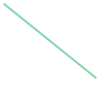

In [59]:
# try to transform the string type to shapely.geometry.linestring type 
# print only one result for checking
shapely.wkt.loads(df5['shape'][0])

In [60]:
# transforming the data type for all rows
df5['shape_'] = df5['shape'].apply(lambda x: shapely.wkt.loads(x))

In [61]:
df5.head(3)

CNN STREET ST_TYPE                CLASS  WIDTH_MIN  WIDTH_RECO  \
0  105000.0   01ST      ST  Downtown Commercial       10.0        12.0   
1  104002.0   01ST      ST  Downtown Commercial       10.0        12.0   
2  104001.0   01ST      ST  Downtown Commercial       10.0        12.0   

   SIDEWALK_F SIDE                                              shape  \
0        15.0    W  LINESTRING (-122.39702 37.78933, -122.39656 37...   
1        15.0    W  LINESTRING (-122.397255 37.789516, -122.39702 ...   
2        15.0    W  LINESTRING (-122.39756 37.789757, -122.397255 ...   

                                              shape_  
0  LINESTRING (-122.39702 37.78933, -122.39656 37...  
1  LINESTRING (-122.397255 37.789516, -122.39702 ...  
2  LINESTRING (-122.39756 37.789757, -122.397255 ...

In [62]:
# transforming dataframe (df5) to GEOdataframe (gdf5)
gdf5 = gpd.GeoDataFrame(df5, crs=df1.crs, geometry=df5['shape_'])
gdf5.head(2)

CNN STREET ST_TYPE                CLASS  WIDTH_MIN  WIDTH_RECO  \
0  105000.0   01ST      ST  Downtown Commercial       10.0        12.0   
1  104002.0   01ST      ST  Downtown Commercial       10.0        12.0   

   SIDEWALK_F SIDE                                              shape  \
0        15.0    W  LINESTRING (-122.39702 37.78933, -122.39656 37...   
1        15.0    W  LINESTRING (-122.397255 37.789516, -122.39702 ...   

                                              shape_  \
0  LINESTRING (-122.39702 37.78933, -122.39656 37...   
1  LINESTRING (-122.397255 37.789516, -122.39702 ...   

                                            geometry  
0  LINESTRING (-122.39702 37.78933, -122.39656 37...  
1  LINESTRING (-122.39726 37.78952, -122.39702 37...

In [63]:
# displaying the sidewalk width range
gdf5['SIDEWALK_F'].describe()

count    16174.000000
mean         8.652776
std         30.897292
min         -3.000000
25%          0.000000
50%         10.000000
75%         15.000000
max       1915.000000
Name: SIDEWALK_F, dtype: float64

<AxesSubplot:>

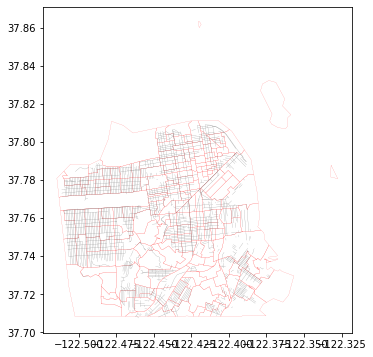

In [64]:
# filter out those less than 15m (below 75% perceptile)
base = SF.plot(color='none', edgecolor='r', linewidth=.1, figsize=(6,6))
gdf5[gdf5['SIDEWALK_F']>=15].plot(ax=base,edgecolor='gray', linewidth=.2, figsize=(5,5), legend=True)

In [66]:
# intersect SF (main dataset) with gdf5 (sidewalk data) and create a new geodataframe called sidewalk
sidewalk=gpd.overlay(gdf5[gdf5['SIDEWALK_F']>=15], SF, how='intersection')

In [67]:
# now every sidwalk data point have a reference column for "groupby"ing back 
sidewalk.head(1)

CNN STREET ST_TYPE                CLASS  WIDTH_MIN  WIDTH_RECO  \
0  105000.0   01ST      ST  Downtown Commercial       10.0        12.0   

   SIDEWALK_F SIDE                                              shape  \
0        15.0    W  LINESTRING (-122.39702 37.78933, -122.39656 37...   

                                              shape_  ...     asthma   lbw  \
0  LINESTRING (-122.39702 37.78933, -122.39656 37...  ...  21.389999  5.85   

    cvd  edu ling   pov  white_pct  african_am  asian_amer  \
0  3.79  4.6  8.7  19.0  54.700001         3.7        30.9   

                                            geometry  
0  LINESTRING (-122.39702 37.78933, -122.39656 37...  

[1 rows x 34 columns]

In [68]:
sidewalk['sidewalk_length']=sidewalk.length
# calculating sidewalk length and store the values to a new column called sidewalk_length

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [69]:
# "groupby"ing back using "TRACTCE"
s=sidewalk.groupby('TRACTCE').sum()

In [70]:
len(SF)

195

In [71]:
# there are 16 census tracts without any sidewalk, because there should be 195 rows
len(s)

179

In [72]:
# Merge only the column 'sidewalk_length' back to SF
SF = SF.merge(s['sidewalk_length'],how='left',  left_on='TRACTCE', right_index=True)

<AxesSubplot:>

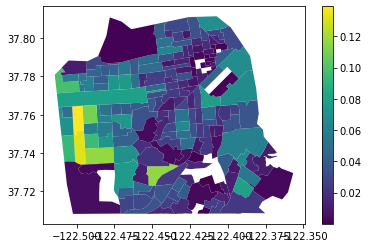

In [73]:
SF.plot(column='sidewalk_length',legend=True)

In [74]:
# Show the null values in the 'sidewalk_length' column
SF[SF['sidewalk_length'].isnull()].head(2)

STATEFP COUNTYFP TRACTCE              AFFGEOID       GEOID    NAME LSAD  \
528      06      075  012401  1400000US06075012401  6075012401  124.01   CT   
532      06      075  017801  1400000US06075017801  6075017801  178.01   CT   

      ALAND  AWATER                                           geometry  ...  \
528   91972       0  POLYGON ((-122.41771 37.78424, -122.41607 37.7...  ...   
532  214052       0  POLYGON ((-122.40493 37.78150, -122.40271 37.7...  ...   

        asthma   lbw   cvd        edu       ling        pov  white_pct  \
528  88.760002  5.63  6.05  31.400000  28.700001  71.199997       24.5   
532  68.430000  7.48  7.92  36.299999  55.599998  58.299999       25.6   

     african_am  asian_amer  sidewalk_length  
528         9.8   25.400000              NaN  
532         3.2   64.599998              NaN  

[2 rows x 25 columns]

In [75]:
# fill up the null values with zeros 
SF['sidewalk_length'].fillna(0, inplace=True)

In [76]:
# check the null values have been filled with zeros
SF[SF['sidewalk_length'].isnull()]

Empty GeoDataFrame
Columns: [STATEFP, COUNTYFP, TRACTCE, AFFGEOID, GEOID, NAME, LSAD, ALAND, AWATER, geometry, tract, zip, pm, traffic, diesel, asthma, lbw, cvd, edu, ling, pov, white_pct, african_am, asian_amer, sidewalk_length]
Index: []

[0 rows x 25 columns]

<AxesSubplot:>

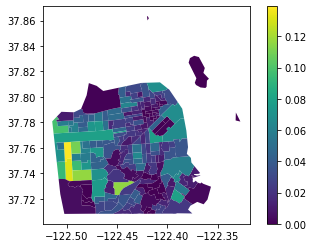

In [77]:
# display the data again
# found that sidewalk length is greater in western part of SF
SF.plot(column='sidewalk_length',legend=True)

#### Bike rack

In [78]:
# load bike rack data
# looking at the json format for how I should extract data I need
url = "https://data.sfgov.org/resource/hn4j-6fx5.geojson"

response = requests.get(url)
results = response.text
data = json.loads(results)
data

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [-122.40533, 37.788067]},
   'properties': {':@computed_region_6qbp_sg9q': '19',
    ':@computed_region_h4ep_8xdi': None,
    'location': 'Hermes',
    ':@computed_region_26cr_cadq': '3',
    'objectid': '12163',
    'globalid': None,
    ':@computed_region_ajp5_b2md': '8',
    'placement': 'SIDEWALK',
    ':@computed_region_qgnn_b9vv': '6',
    'install_yr': '2004',
    'install_mo': '0',
    'address': '125 GRANT AVE',
    'lon': '-122.405341',
    'street': 'GRANT',
    'racks': '1',
    ':@computed_region_jwn9_ihcz': '19',
    ':@computed_region_9jxd_iqea': '5',
    ':@computed_region_696y_nzzn': '43',
    'spaces': '2',
    'lat': '37.788072'}},
  {'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [-122.42022, 37.788628]},
   'properties': {':@computed_region_6qbp_sg9q': '50',
    ':@computed_region_h4ep_8xdi': None,
    'location': 'Polk Bush Garage',
 

In [79]:
# Extract lat/lon data of bike racks
df6 = pd.DataFrame(columns=['lon','lat'])

for i in range(len(data['features'])):
    df6.loc[i] = data['features'][i]['geometry']['coordinates']
df6.head

<bound method NDFrame.head of             lon        lat
0   -122.405330  37.788067
1   -122.420220  37.788628
2   -122.405640  37.789780
3   -122.392520  37.793137
4   -122.440060  37.729187
..          ...        ...
995 -122.417050  37.764256
996 -122.429405  37.767498
997 -122.419010  37.758390
998 -122.412610  37.791610
999 -122.442170  37.752163

[1000 rows x 2 columns]>

In [80]:
# display the dataframe
shape = [Point(xy) for xy in zip(df6['lon'],df6['lat'])]
gdf6 = gpd.GeoDataFrame(df6, crs=df1.crs, geometry=shape)
gdf6.head()

lon        lat                     geometry
0 -122.40533  37.788067  POINT (-122.40533 37.78807)
1 -122.42022  37.788628  POINT (-122.42022 37.78863)
2 -122.40564  37.789780  POINT (-122.40564 37.78978)
3 -122.39252  37.793137  POINT (-122.39252 37.79314)
4 -122.44006  37.729187  POINT (-122.44006 37.72919)

<AxesSubplot:>

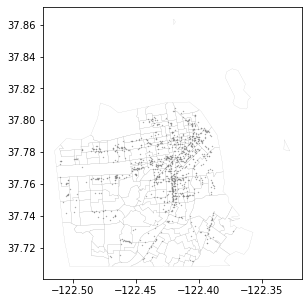

In [81]:
# plot the bike rack data
base = SF.plot(color='none', edgecolor='gray', linewidth=.1, figsize=(5,5))
gdf6.plot(ax=base, color='grey', markersize=.1)

In [82]:
# using spatial join and groupby operation to prepare data
# counting bike rack numbers within each census tract
c=gpd.sjoin(SF, gdf6).groupby('GEOID').count()

In [83]:
# Randomly pick 'STATEFP' and store the count value to a new column called 'bikerack_count'
c['bikerack_count']=c['STATEFP']
c.head(1)

STATEFP  COUNTYFP  TRACTCE  AFFGEOID  NAME  LSAD  ALAND  AWATER  \
GEOID                                                                         
6075010100        3         3        3         3     3     3      3       3   

            geometry  tract  ...  ling  pov  white_pct  african_am  \
GEOID                        ...                                     
6075010100         3      3  ...     3    3          3           3   

            asian_amer  sidewalk_length  index_right  lon  lat  bikerack_count  
GEOID                                                                           
6075010100           3                3            3    3    3               3  

[1 rows x 28 columns]

In [84]:
# merge the 'bikerack_count' and SF main dataset
SF=SF.merge(c['bikerack_count'],how='left',on='GEOID')

In [85]:
# fill up null values with zero to represent no bike rack found
SF['bikerack_count'].fillna(0, inplace=True)

<AxesSubplot:>

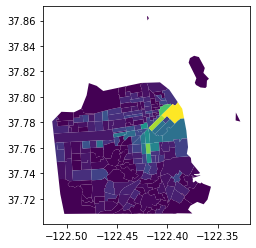

In [86]:
# found that bike racks concentrate on the northeasten part of SF
SF.plot(column='bikerack_count')

#### Bike sharing station

In [87]:
# load bikesharing station data
url="https://data.sfgov.org/resource/7jbp-yzp3.json"

response = requests.get(url)
results = response.text
# data = json.loads(results)
data= pd.read_json(results)

In [91]:
# transform the data's latlon to float type 
# create a geodataframe 
fil = lambda x: float(x)
shape = [Point(xy) for xy in zip(data.station_longitude.map(fil), data.station_latitude.map(fil))]
gdf7 = gpd.GeoDataFrame(data, crs=df1.crs, geometry=shape)
gdf7.head(2)

station_id                                      station_name  \
0          17  Embarcadero BART Station (Beale St at Market St)   
1          30    San Francisco Caltrain (Townsend St at 4th St)   

  station_id_domo has_kiosk  dock_count  station_latitude  station_longitude  \
0        SF-E29-3      true          29         37.792251        -122.397086   
1          SF-J29      true          19         37.776598        -122.395282   

   region_id                         shape                     geometry  
0        3.0  POINT (-122.39707 37.792248)  POINT (-122.39709 37.79225)  
1        3.0  POINT (-122.39527 37.776592)  POINT (-122.39528 37.77660)

In [92]:
# Drop missing data
gdf7=gdf7[gdf7.station_latitude!=0]

<AxesSubplot:>

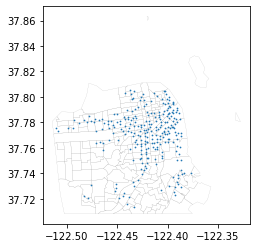

In [93]:
# display the result
# found bikesharing station concentrate northeastern part of SF, similar to bike rack facilities
base= SF.plot(color='none', edgecolor='gray', linewidth=.1, figsize=(4,4))
gdf7[gdf7["station_id_domo"].str.contains('SF')].plot(ax=base, markersize=.5)

In [94]:
# create a new column to store a value that represents the minimum value to the closest bike sharing station
SF['min_dist_to_bs'] = SF.geometry.apply(lambda g: gdf7[gdf7["station_id_domo"].str.contains('SF')].distance(g).min())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [95]:
SF.head(2)

STATEFP COUNTYFP TRACTCE              AFFGEOID       GEOID NAME LSAD  \
0      06      075  010200  1400000US06075010200  6075010200  102   CT   
1      06      075  011200  1400000US06075011200  6075011200  112   CT   

    ALAND  AWATER                                           geometry  ...  \
0  515958  295388  POLYGON ((-122.42667 37.80964, -122.42488 37.8...  ...   
1  177414       0  POLYGON ((-122.41629 37.79389, -122.41522 37.7...  ...   

    cvd   edu  ling   pov  white_pct  african_am  asian_amer  sidewalk_length  \
0  4.39   1.6   1.1  12.1  81.099998         0.6   10.200000         0.035729   
1  3.71  10.6  13.1  26.0  55.099998         1.5   35.099998         0.008231   

   bikerack_count  min_dist_to_bs  
0             2.0         0.00000  
1             1.0         0.00264  

[2 rows x 27 columns]

<AxesSubplot:>

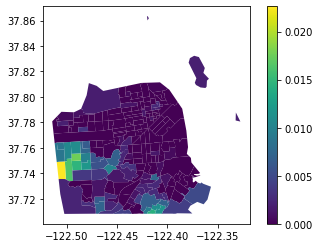

In [96]:
# display the result, accssibility to bike sharing station
SF.plot(column='min_dist_to_bs',legend=True)

#### Preparing data for GWR

In [97]:
SF.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [98]:
SF_3857 = SF.to_crs("EPSG:3857")
SF_3857.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [99]:
# create two columns 'x' and 'y' to store x,y coordinates using centroid function
SF_3857["x"]=SF_3857.centroid.map(lambda p: p.x)
SF_3857["y"]=SF_3857.centroid.map(lambda p: p.y)
SF_3857.head(2)

STATEFP COUNTYFP TRACTCE              AFFGEOID       GEOID NAME LSAD  \
0      06      075  010200  1400000US06075010200  6075010200  102   CT   
1      06      075  011200  1400000US06075011200  6075011200  112   CT   

    ALAND  AWATER                                           geometry  ...  \
0  515958  295388  POLYGON ((-13628474.780 4552569.154, -13628274...  ...   
1  177414       0  POLYGON ((-13627319.401 4550350.608, -13627199...  ...   

   ling   pov  white_pct  african_am  asian_amer  sidewalk_length  \
0   1.1  12.1  81.099998         0.6   10.200000         0.035729   
1  13.1  26.0  55.099998         1.5   35.099998         0.008231   

   bikerack_count  min_dist_to_bs             x             y  
0             2.0         0.00000 -1.362797e+07  4.551968e+06  
1             1.0         0.00264 -1.362692e+07  4.550221e+06  

[2 rows x 29 columns]

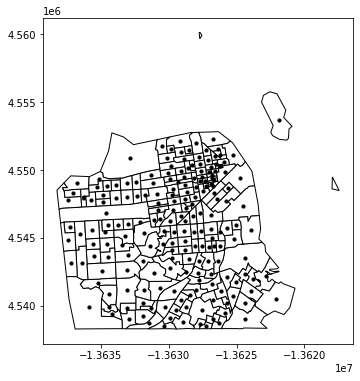

In [100]:
fig, ax = plt.subplots(figsize = (6, 6))

SF_3857.plot(ax=ax, **{'edgecolor': 'black', 'facecolor': 'white'})
SF_3857.centroid.plot(ax = ax, c = 'black', markersize=10)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:236: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/opt/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: setting k to 1
  Warn("Warning: setting k to %d" % k_q, UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:236: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/opt/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


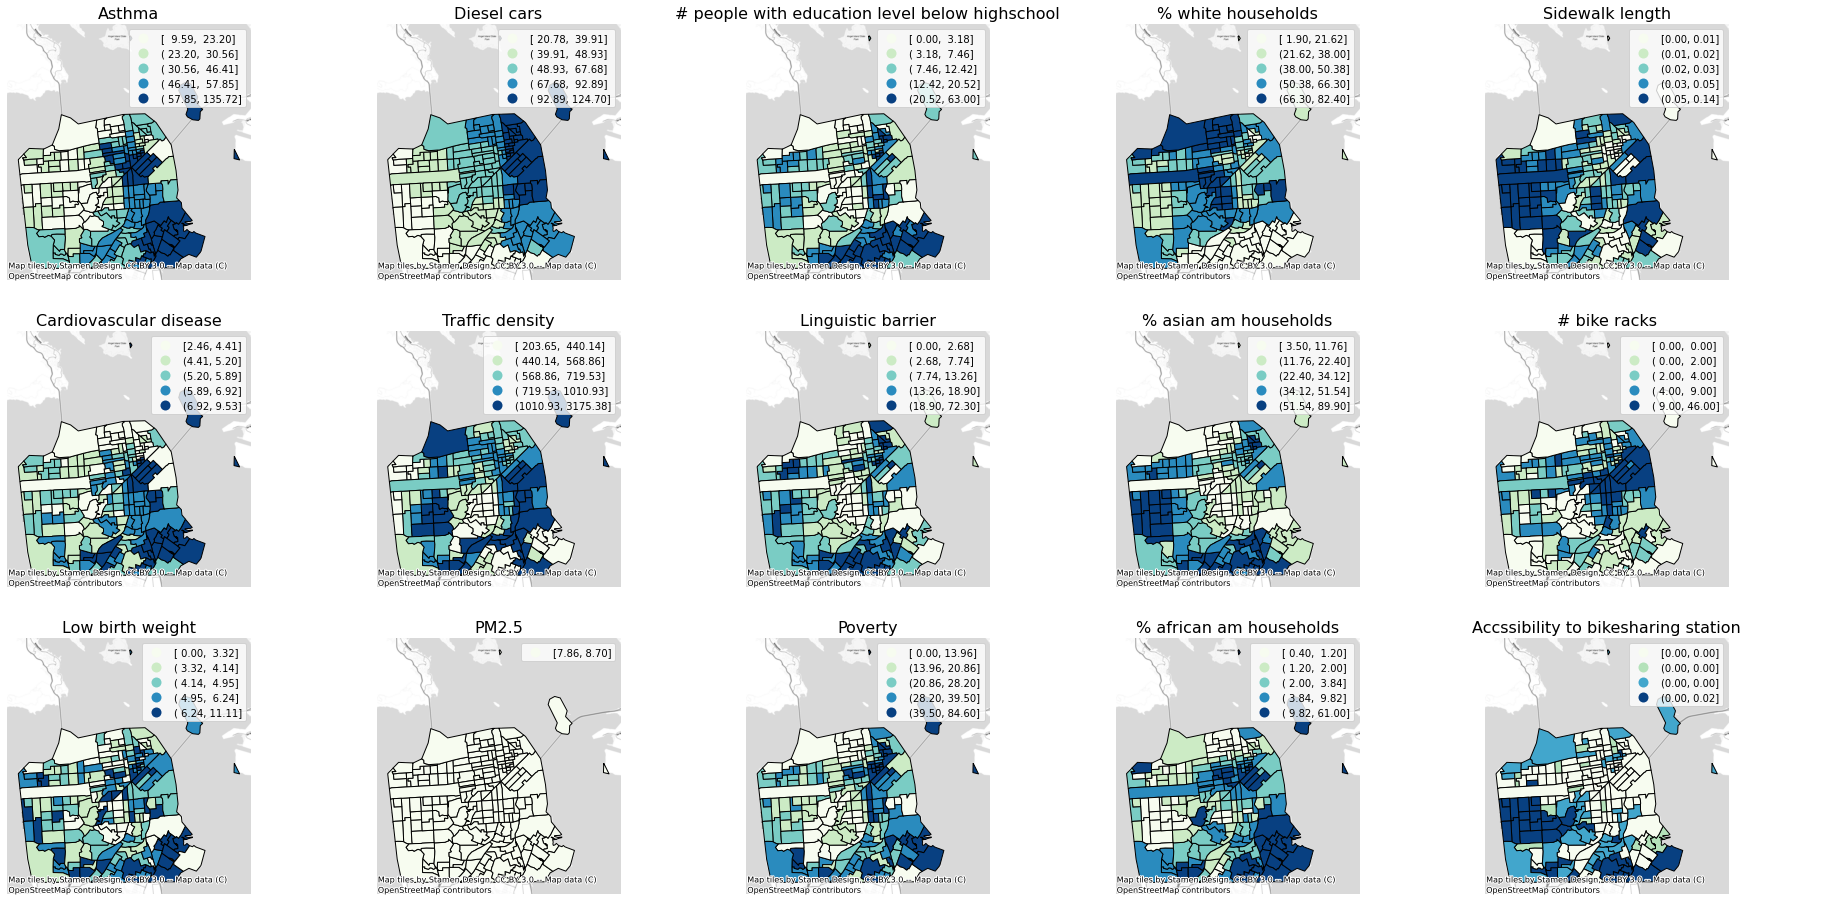

In [101]:
#Create choropleth quantile maps of each variable (including three new physical activity variables) 
f,(ax1,ax2,ax3) = plt.subplots(3,5,figsize=(32,16))


# Health
SF_3857.plot(column='asthma', legend=True, ax=ax1[0],
        scheme="quantiles",  k=5, cmap='GnBu',edgecolor='black')
ax1[0].set_title("Asthma", fontsize=16)

SF_3857.plot(column='cvd', legend=True, ax=ax2[0],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax2[0].set_title("Cardiovascular disease", fontsize=16)

SF_3857.plot(column='lbw', legend=True, ax=ax3[0],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax3[0].set_title("Low birth weight", fontsize=16)


# Env
SF_3857.plot(column='diesel', legend=True, ax=ax1[1],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax1[1].set_title("Diesel cars", fontsize=16)

SF_3857.plot(column='traffic', legend=True, ax=ax2[1],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax2[1].set_title("Traffic density", fontsize=16)

SF_3857.plot(column='pm', legend=True, ax=ax3[1],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax3[1].set_title("PM2.5", fontsize=16)


# Socioeconomic
SF_3857.plot(column='edu', legend=True, ax=ax1[2],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax1[2].set_title("# people with education level below highschool", fontsize=16)

SF_3857.plot(column='ling', legend=True, ax=ax2[2],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax2[2].set_title("Linguistic barrier", fontsize=16)

SF_3857.plot(column='pov', legend=True, ax=ax3[2],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax3[2].set_title("Poverty", fontsize=16)

# Ethnicity
SF_3857.plot(column='white_pct', legend=True, ax=ax1[3],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax1[3].set_title("% white households", fontsize=16)

SF_3857.plot(column='asian_amer', legend=True, ax=ax2[3],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax2[3].set_title("% asian am households", fontsize=16)

SF_3857.plot(column='african_am', legend=True, ax=ax3[3],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax3[3].set_title("% african am households", fontsize=16)


# Physical activity
SF_3857.plot(column='sidewalk_length', legend=True, ax=ax1[4],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax1[4].set_title("Sidewalk length", fontsize=16)

SF_3857.plot(column='bikerack_count', legend=True, ax=ax2[4],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax2[4].set_title("# bike racks", fontsize=16)

SF_3857.plot(column='min_dist_to_bs', legend=True, ax=ax3[4],
        scheme='quantiles', cmap='GnBu', k=5, edgecolor='black')
ax3[4].set_title("Accssibility to bikesharing station", fontsize=16)





for i in range(5):
    ax1[i].axis('off')
    ax2[i].axis('off')
    ax3[i].axis('off')
    cx.add_basemap(ax1[i], crs=SF_3857.crs.to_string(), source=cx.providers.Stamen.TonerLite)
    cx.add_basemap(ax2[i], crs=SF_3857.crs.to_string(), source=cx.providers.Stamen.TonerLite)
    cx.add_basemap(ax3[i], crs=SF_3857.crs.to_string(), source=cx.providers.Stamen.TonerLite)

 

### Results of SF-level correlation analysis including physical activity
Conducting again the correlation analysis for three dimensions of environment, health, and physical activity shows that, in the dimension of physical activity, although walking facility can reduce asthma (R=-.28) whereas biking facilities (i.e. bike rack and bike sharing station) seem not to, but even help increase asthma rate. Namely, more sidewalk longer than 15m could help improve health outcome by reducing asthma rate; however, more bike racks and shorter distance to bike sharing facility could do the opposite. Therefore, in the regression model, I would introduce a interaction term to reflect this effect.

Further observing the relationship of biking facility and environmental air pollution exposure, we can find that these facilities concentrate in polluted tracts, which could let cyclists inhale more particulates as their inhalation rate would drastically increase while cycling (around 3-6 times than in sedentary mode).

Note that "min_dist_to_bs" is the distance matrix which should be treated inversely, i.e. the lower the value, the higher the accessibility.

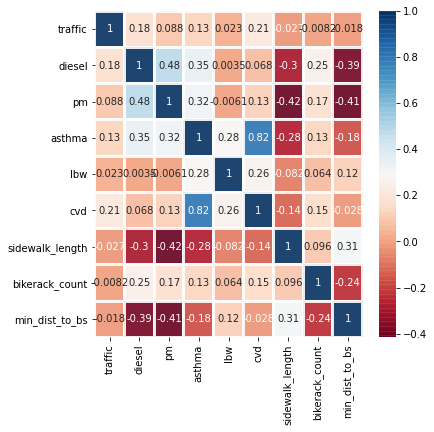

In [102]:
dfData = SF[['traffic','diesel','pm','asthma','lbw','cvd','sidewalk_length', 'bikerack_count', 'min_dist_to_bs']].corr()
plt.subplots(figsize=(6, 6)) 

sns.heatmap(dfData, annot=True, vmax=1, square=False, cmap="RdBu", alpha=.9, linewidths=2, linecolor='white', cbar=True)
plt.show()


### Global regression analaysis: steps and major findings

Below is multiple global regression analyses. Firstly, I run two regression models, one of which includes 12 variables and the other adds two interaction terms. In the first model, the adjusted R-squared value is .665 and the signs of coefficients for those p<.05 are all expected (i.e. diesel and three ethnic-related variables). 

Further, it can be observed that the p-values for the two bike-related variables are less than 0.1, but their signs, as mentioned earlier, cannot represent the benefitial effect of physical activity. To this end, the second model includes the interaction terms called "bike_diesel_rack" and "bike_diesel_bshare". The result of the second model not only slightly increase the R-squared values, but also increase the significance "bikerack" (p-value decrease to .006) and the sign of coefficient of the interaction term "bike_diesel_rack" is negative, as expected, and significant (p=.017).

Additionally, particulate matter concentration ('pm') and all socoieconomic status variables are not statistically significant. The former could be because the PM concentration below 10 can already be considered very clean and the data is averaged on a yearly basis. The latter could be because their strong collinearities with ethnic variables that have strongly explained the variances of asthma rate.

Finally, I use Backward stepwise regression model (removing the most insignicant variable at a time) and ultimately have the third regression model which has a adjusted R-squared value of 0.67 and six variables that are all statistically significant (i.e. diesel, white_pct, african_am, asian_amer, bikerack_count, and the interaction term "bike_diesel_rack"). The Durbin-Watson statistic value being 1.92 shows that there could be little autocorrelation detected.


In [103]:
# First model - 12 variables with no interaction term

y, X = dmatrices('asthma ~ pm + traffic + diesel +edu +ling + pov + white_pct + african_am + asian_amer +sidewalk_length + bikerack_count + min_dist_to_bs', 
                 data=SF_3857, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 asthma   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     33.03
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           1.90e-39
Time:                        09:40:29   Log-Likelihood:                -817.60
No. Observations:                 195   AIC:                             1661.
Df Residuals:                     182   BIC:                             1704.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          68.5708     53.229     

In [104]:
SF_3857['bike_diesel_rack']=SF_3857['diesel']*SF_3857['bikerack_count']

In [105]:
SF_3857['bike_diesel_bshare']=SF_3857['diesel']*SF_3857['min_dist_to_bs']

In [106]:
# Second model - 14 variables with two interaction terms

y, X = dmatrices('asthma ~ pm + traffic + diesel +edu +ling + pov + white_pct + african_am + asian_amer +sidewalk_length + bikerack_count + min_dist_to_bs + bike_diesel_rack + bike_diesel_bshare', 
                 data=SF_3857, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 asthma   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     29.41
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           3.32e-39
Time:                        09:40:59   Log-Likelihood:                -814.31
No. Observations:                 195   AIC:                             1659.
Df Residuals:                     180   BIC:                             1708.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             71.0737     52

In [107]:
# Third model (result of backward stepwise regression)
y, X = dmatrices('asthma ~diesel + white_pct + african_am + asian_amer + bikerack_count + bike_diesel_rack', 
                 data=SF_3857, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
residuals = res.resid
predicted = res.fittedvalues
observed = y
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 asthma   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     66.61
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           6.35e-44
Time:                        09:41:05   Log-Likelihood:                -819.21
No. Observations:                 195   AIC:                             1652.
Df Residuals:                     188   BIC:                             1675.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           73.6118      9.983  

### Spatial autocorrelation and GWR analysis results:
Globally, the sptaial autocorrelation analysis shows that there are two hotspots for asthma rate; one in southern SF and the other near SF city hall. These two places share a common spatial characteristics, i.e. higher african household rate. The high global moran's I shows that generally asthma rates among SF are spatially concentrated, which supports the use of GWR analysis.

In GWR analysis, the adjusted R2 value increase to 0.75 from 0.68. And all the variables employed in the global regression remain statistically significant at 0.01 confidence level, except for the interaction term which however has a very low p-value of 0.02. From the surface maps, one major finding is that the "multiplier effect" concentrated in the southeatern part of SF (red/hot spot) where more african households live in and higher diesel pm concentration exist; biking here would tend to only increase the health risk probably due to high inhalation rate during active biking. Further, Asian household, though facing many socioeconomic barrier linguistically or economically, are less prone to asthmatic risk, whereas white households are less vulnerable in terms of all dimensions.


The local model fit map shows that the model built in this project can very well and correctly predict the asthma rate inthe southern SF, although, according to a rule of thumb, some census tracts where VIFs are higher than 10, and/or VDPs are higher than 0.5, and thus multicollinearities could exist. Overall, diesel and african households seem to have less multicollinearity issue.
 
 
 
 
 
 
 
 

#### Spatial autocorrelation

In [108]:
SF_3857.crs
SF_3857.reset_index(drop=True, inplace=True)
SF_3857.head(2)

# resetting value for caculating kernal weight

STATEFP COUNTYFP TRACTCE              AFFGEOID       GEOID NAME LSAD  \
0      06      075  010200  1400000US06075010200  6075010200  102   CT   
1      06      075  011200  1400000US06075011200  6075011200  112   CT   

    ALAND  AWATER                                           geometry  ...  \
0  515958  295388  POLYGON ((-13628474.780 4552569.154, -13628274...  ...   
1  177414       0  POLYGON ((-13627319.401 4550350.608, -13627199...  ...   

   white_pct african_am  asian_amer  sidewalk_length  bikerack_count  \
0  81.099998        0.6   10.200000         0.035729             2.0   
1  55.099998        1.5   35.099998         0.008231             1.0   

   min_dist_to_bs             x             y  bike_diesel_rack  \
0         0.00000 -1.362797e+07  4.551968e+06        147.940002   
1         0.00264 -1.362692e+07  4.550221e+06        111.129997   

   bike_diesel_bshare  
0            0.000000  
1            0.293383  

[2 rows x 31 columns]

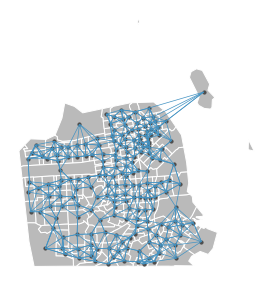

In [110]:
w = ps.weights.Kernel.from_dataframe(SF_3857, k=5, fixed=False, function='gaussian')
plot_spatial_weights(w, SF_3857, figsize=(5,5));

# w = ps.weights.Queen.from_dataframe(SF_3857)
# plot_spatial_weights(w, SF_3857, figsize=(5,5));

In [111]:
# Global Moran's I
y, X = dmatrices('asthma ~ pm + traffic + diesel +edu +ling + pov + white_pct + african_am + asian_amer +sidewalk_length + bikerack_count + min_dist_to_bs', 
                 data=SF_3857, return_type='dataframe')

moran = esda.Moran(y, w)
moran.I

0.8232597476169629

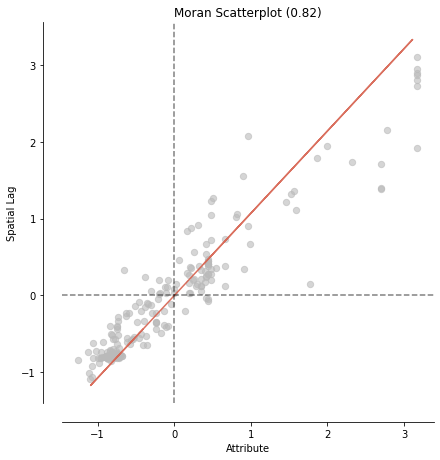

In [112]:
# Plotting the result
# A Moran's I of .82 is quite high
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

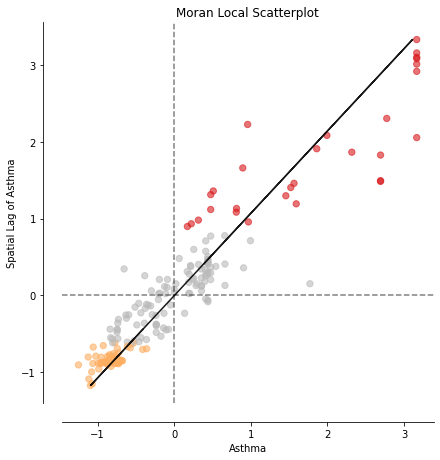

In [113]:
# calculating Moran_Local and plotting the result
moran_loc = esda.moran.Moran_Local(y, w)
fig, ax =  splot.esda.moran_scatterplot(moran_loc, p=0.05)
ax.set_xlabel('Asthma')
ax.set_ylabel('Spatial Lag of Asthma')
plt.show()

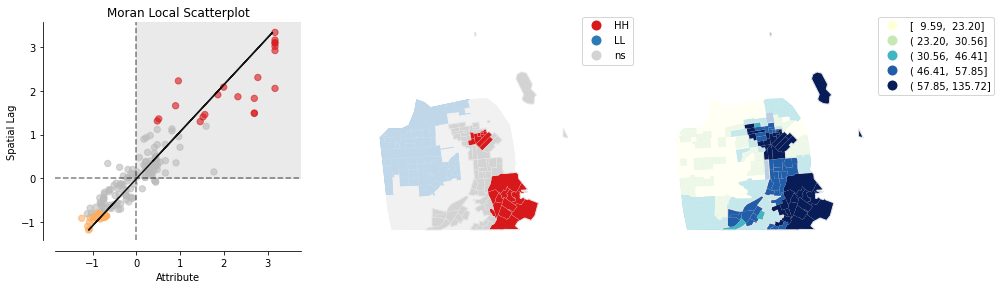

In [114]:
# plotting the result on the map
# two hotspots and one large coldspot can be found, which are very similar to the residential patterns of white and Asian households

moran_loc = esda.moran.Moran_Local(y,w)
# splot.esda.lisa_cluster(moran_loc, SF_3857, p=0.05, alpha=.9, figsize = (5,5))
splot.esda.plot_local_autocorrelation(moran_loc, SF_3857, 'asthma', p=0.01, quadrant=1)
plt.show()

#### GWR

In [115]:
#Prepare dataset inputs for GWR
g_y = SF_3857['asthma'].values.reshape((-1, 1))
g_X = SF_3857[['diesel',  'white_pct', 'african_am', 'asian_amer', 'bikerack_count','bike_diesel_rack']].values
u = SF_3857['x']
v = SF_3857['y']
g_coords = list(zip(u, v))

In [116]:
#Calibrate a GWR model for Chicago dataset using computationally selected~bandwidth (optimizes using AIC)
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search()
print('Computationally selected bandwidth: ',gwr_bw)

gwr_model = GWR(g_coords, g_y, g_X, gwr_bw)
gwr_results = gwr_model.fit()
print('Residual sum of squares: ', gwr_results.resid_ss)

Computationally selected bandwidth:  83.0
Residual sum of squares:  34152.95836313484


In [117]:
gwr_results.summary();

# X1:'diesel', X2:'white_pct', X3:'african_am', X4:'asian_amer', X5:'bikerack_count', X6:'bike_diesel_rack'

Model type                                                         Gaussian
Number of observations:                                                 195
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          50885.124
Log-likelihood:                                                    -819.215
AIC:                                                               1652.430
AICc:                                                              1655.204
BIC:                                                              49893.800
R2:                                                                   0.680
Adj. R2:                                                              0.670

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [118]:
#Prepare GWR results for mapping
#Add GWR parameters to GeoDataframe
SF_3857['gwr_intercept'] = gwr_results.params[:,0]
SF_3857['gwe_diesel'] = gwr_results.params[:,1]
SF_3857['gwr_white'] = gwr_results.params[:,2]
SF_3857['gwr_african'] = gwr_results.params[:,3]
SF_3857['gwr_asian'] = gwr_results.params[:,4]
SF_3857['gwr_bikerack_count'] = gwr_results.params[:,5]

#Obtain t-vals filtered based on multiple testing correction
gwr_filtered_t = gwr_results.filter_tvals()

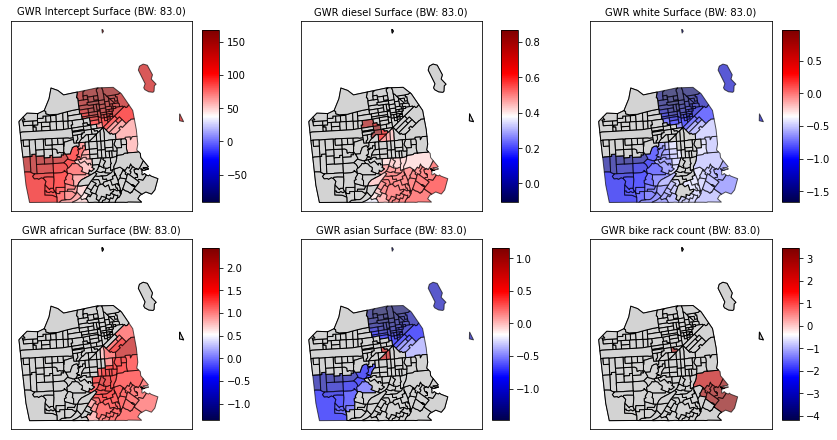

In [119]:
# Plot estimators
fig, (axes1, axes2) = plt.subplots(nrows=2, ncols=3, figsize=(12,6), constrained_layout=True)
ax0 = axes1[0]
ax0.set_title('GWR Intercept Surface (BW: ' + str(gwr_bw) +')', fontsize=10)
ax1 = axes1[1]
ax1.set_title('GWR diesel Surface (BW: ' + str(gwr_bw) +')', fontsize=10)
ax2 = axes1[2]
ax2.set_title('GWR white Surface (BW: ' + str(gwr_bw) +')', fontsize=10)
ax3 = axes2[0]
ax3.set_title('GWR african Surface (BW: ' + str(gwr_bw) +')', fontsize=10)
ax4 = axes2[1]
ax4.set_title('GWR asian Surface (BW: ' + str(gwr_bw) +')', fontsize=10)
ax5 = axes2[2]
ax5.set_title('GWR bike rack count (BW: ' + str(gwr_bw) +')', fontsize=10);



SF_3857.plot('gwr_intercept', legend=True, cmap='seismic', ax=ax0,  **{'edgecolor':'black', 'alpha':.65},legend_kwds={'shrink': .9})
if (gwr_filtered_t[:,0] == 0).any():
    SF_3857[gwr_filtered_t[:,0] == 0].plot(color='lightgrey', ax=ax0, **{'edgecolor':'black'})

SF_3857.plot('gwe_diesel', legend=True,cmap='seismic', ax=ax1,  **{'edgecolor':'black', 'alpha':.65},legend_kwds={'shrink': .9})
if (gwr_filtered_t[:,1] == 0).any():
    SF_3857[gwr_filtered_t[:,1] == 0].plot(color='lightgrey', ax=ax1, **{'edgecolor':'black'})
    
SF_3857.plot('gwr_white', legend=True, cmap='seismic', ax=ax2,  **{'edgecolor':'black', 'alpha':.65},legend_kwds={'shrink': .9})
if (gwr_filtered_t[:,2] == 0).any():
    SF_3857[gwr_filtered_t[:,2] == 0].plot(color='lightgrey', ax=ax2, **{'edgecolor':'black'})

SF_3857.plot('gwr_african', legend=True, cmap='seismic', ax=ax3,  **{'edgecolor':'black', 'alpha':.65},legend_kwds={'shrink': .9})
if (gwr_filtered_t[:,3] == 0).any():
    SF_3857[gwr_filtered_t[:,3] == 0].plot(color='lightgrey', ax=ax3, **{'edgecolor':'black'})

SF_3857.plot('gwr_asian', legend=True, cmap='seismic', ax=ax4,  **{'edgecolor':'black', 'alpha':.65},legend_kwds={'shrink': .9})
if (gwr_filtered_t[:,4] == 0).any():
    SF_3857[gwr_filtered_t[:,4] == 0].plot(color='lightgrey', ax=ax4, **{'edgecolor':'black'})
    
SF_3857.plot('gwr_bikerack_count', legend=True, cmap='seismic', ax=ax5,  **{'edgecolor':'black', 'alpha':.65},legend_kwds={'shrink': .9})
if (gwr_filtered_t[:,5] == 0).any():
    SF_3857[gwr_filtered_t[:,5] == 0].plot(color='lightgrey', ax=ax5, **{'edgecolor':'black'});

    
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)

ax5.get_xaxis().set_visible(False)
ax5.get_yaxis().set_visible(False);


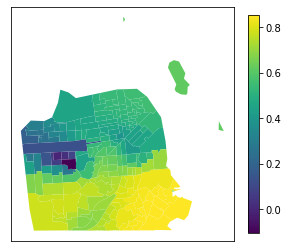

In [120]:
#Local model fit
SF_3857['R2'] = gwr_results.localR2
SF_3857.plot('R2', legend = True, figsize=(5,5),legend_kwds={'shrink': .8})
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
#plt.savefig('local_R2')
plt.show()

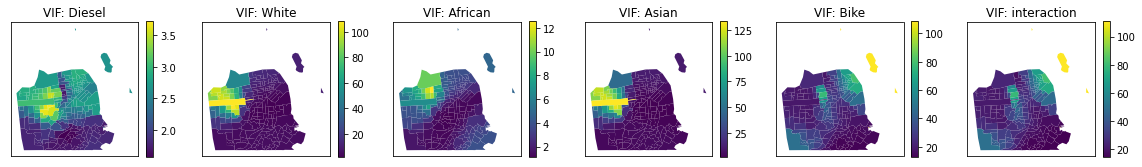

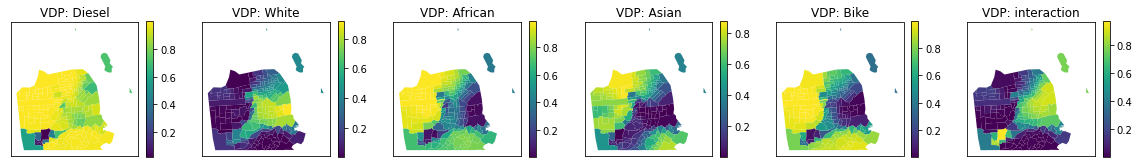

In [121]:
VIF = gwr_results.local_collinearity()[1]
VDP = gwr_results.local_collinearity()[3]

names = ['Diesel','White','African','Asian','Bike','interaction']

fig, ax = plt.subplots(1, 6, figsize = (20, 5))
for col in range(6):
    SF_3857['vif'] = VIF[:, col]
    SF_3857.plot('vif', ax = ax[col], legend = True, legend_kwds={'shrink': .5})
    ax[col].set_title('VIF: ' + names[col])
    ax[col].get_xaxis().set_visible(False)
    ax[col].get_yaxis().set_visible(False)
    

fig, ax = plt.subplots(1, 6, figsize = (20, 5))
for col in range(6):
    SF_3857['vdp'] = VDP[:, col]
    SF_3857.plot('vdp', ax = ax[col], legend = True, legend_kwds={'shrink': .5})
    ax[col].set_title('VDP: ' + names[col])
    ax[col].get_xaxis().set_visible(False)
    ax[col].get_yaxis().set_visible(False)


# PART 3: Interactive mapping with Pydeck, OSMNX, Folium
## 1. Pydeck - grid, heatmap, trip layers 
## 2. OSM network analysis and Folium maps

This part applies pydeck module to display the bike facility data and use OSM network analysis to calculate the shortest route for a OD-pair manually input by users. This can then be mapped onto folium and pydeck (Mapbox) interactive maps with air pollution exposure and biking facility along their travel.

In [133]:
# Display bike rack data using Gridlayer from Mapbox

bike_rack = pdk.Layer(
    'GridLayer',
    df6,
    get_position=['lon', 'lat'],
    auto_highlight=True,
    elevation_scale=150,
    pickable=True,
    elevation_range=[0, 30],
    extruded=True,
    opacity=.3,
    coverage=.7)

view_state = pdk.ViewState(
    longitude=-122.415,
    latitude=37.8023,
    zoom=9,
    min_zoom=1,
    max_zoom=15,
    pitch=50,
    bearing=30)

r = pdk.Deck(layers=[bike_rack], initial_view_state=view_state)
r.to_html('hexagon-example.html')

In [147]:
# Display bike sharing station data using Heatmaplayer from Mapbox



view = pdk.ViewState(
    longitude=-122.455,
    latitude=37.7423,
    zoom=11,
    min_zoom=1,
    max_zoom=15)


COLOR_SCALE = [
    [90, 249, 232],
    [70, 204, 197],
    [55, 150, 150],
    [20, 100, 100],
]

bike_sharing = pdk.Layer(
    "HeatmapLayer",
    data=gdf7,
    opacity=0.9,
    get_position=["station_longitude", "station_latitude"],
    aggregation='"MEAN"',
    color_range=COLOR_SCALE,
    threshold=1,
    get_weight="dock_count",
    pickable=True,
)




r = pdk.Deck(
    layers=bike_sharing,
    initial_view_state=view,
    tooltip={"text": "Concentration of bike-sharing decks in orange"},
)

r.to_html("heatmap_layer.html")

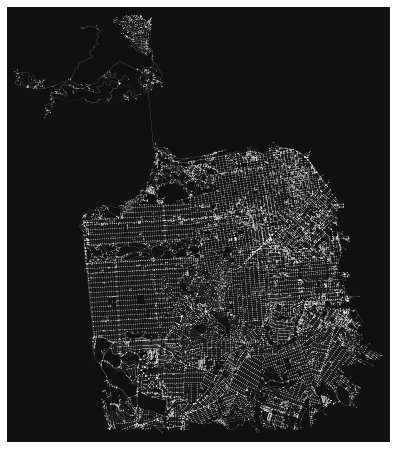

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [125]:
# Create a osmnx-graph called G_bike to represent bike network and displaying it

G_bike = ox.graph.graph_from_bbox(37.86,37.7,-122.325,-122.55,network_type='bike')
ox.plot.plot_graph(G_bike,ax=None, figsize=(8, 8), bgcolor='#111111', 
                   node_color='w', node_size=.5, node_alpha=None, node_edgecolor='none', node_zorder=1, 
                   edge_color='#999999', edge_linewidth=.1, edge_alpha=None, bbox=None)

In [126]:
# input data for origin and destination
# here I assume that I am going to "Taiwan's Restaurant, SF" from "Hunter's Point, SF"

origin_input = input()
destination_input = input()

Hunter's Point, SF
Taiwan Restaurant, SF


In [148]:
# using geocoder to transform the string-type address to latlon type coordinates
origin = ox.geocoder.geocode(origin_input)
destination = ox.geocoder.geocode(destination_input) 

In [149]:
# showing origin's latlon
origin 

(37.7267715, -122.3715718)

In [150]:
# showing destination's latlon
destination

(37.7828379, -122.464162)

In [151]:
# calculting the distance between the OD pair
ox.distance.euclidean_dist_vec(origin[0], origin[1], destination[0], destination[1])

0.10824225766769899

In [152]:
# getting the nearest edge ID for origin and destination
ii_bike=ox.distance.get_nearest_edge(G_bike, origin)
jj_bike=ox.distance.get_nearest_edge(G_bike, destination)

In [153]:
# showing edge ID
ii_bike

(65320592, 65322415, 0)

In [154]:
# showing edge ID
jj_bike

(65287668, 65302772, 0)

In [155]:
# showing edge IDs along the shortest path for the OD pair
path_bike = ox.distance.shortest_path(G_bike, ii_bike[0], jj_bike[0], weight='length')
path_bike

[65320592,
 65320588,
 65320580,
 65340028,
 65366369,
 65355023,
 6923676856,
 6923676854,
 65357496,
 5443154347,
 65336170,
 65356216,
 65356217,
 4152343425,
 65292295,
 65292302,
 65292307,
 5443156969,
 65292311,
 65356450,
 65326005,
 4152362122,
 65325985,
 2609017284,
 2609017285,
 65359954,
 5217784053,
 2609017288,
 2609017292,
 2609017295,
 65325131,
 258964502,
 258964500,
 258964498,
 65291436,
 4941850058,
 4911186553,
 65291439,
 4941850041,
 4941849314,
 4941850113,
 65291441,
 6380947473,
 4941850030,
 6381005366,
 4941850037,
 65291448,
 65291456,
 4155016904,
 5443322848,
 5443322851,
 5443322855,
 65291466,
 65282263,
 65291481,
 65291484,
 4941850246,
 1130257461,
 4941850602,
 1130257483,
 4941850607,
 65291486,
 4941850609,
 4941850619,
 65291490,
 65291491,
 5443322489,
 4941850440,
 4941850428,
 4941850435,
 4941850432,
 65291494,
 65283935,
 65283938,
 266910523,
 65288985,
 65308820,
 265666762,
 65322282,
 65322284,
 65290335,
 65322285,
 65322294,
 6531779

In [156]:
# the total count of the edges on the shortest path
len(path_bike)

193

In [157]:
# displaying all the info for all edges
ox.utils_graph.get_route_edge_attributes(G_bike, path_bike, attribute=None, minimize_key='length', retrieve_default=None)

[{'osmid': 8917551,
  'name': 'Navy Road',
  'highway': 'residential',
  'oneway': False,
  'length': 66.526,
  'geometry': <shapely.geometry.linestring.LineString at 0x1a63ac5290>},
 {'osmid': 8917551,
  'name': 'Navy Road',
  'highway': 'residential',
  'oneway': False,
  'length': 23.156,
  'geometry': <shapely.geometry.linestring.LineString at 0x1a63ac5a50>},
 {'osmid': 255178095,
  'name': 'Kirkwood Avenue',
  'highway': 'residential',
  'oneway': False,
  'length': 59.906,
  'geometry': <shapely.geometry.linestring.LineString at 0x1a63ac5850>},
 {'osmid': 255178095,
  'name': 'Kirkwood Avenue',
  'highway': 'residential',
  'oneway': False,
  'length': 17.508,
  'geometry': <shapely.geometry.linestring.LineString at 0x1a65cdd6d0>},
 {'osmid': 255178095,
  'name': 'Kirkwood Avenue',
  'highway': 'residential',
  'oneway': False,
  'length': 52.312,
  'geometry': <shapely.geometry.linestring.LineString at 0x1a67126ad0>},
 {'osmid': 255178095,
  'name': 'Kirkwood Avenue',
  'highway

In [158]:
# Mapping the shortest route and diesel PM onto the folium platform

diesel_map = folium.Map([37.7556, -122.4399], zoom_start = 12, tiles='Stamen Toner' )
tracts = SF.set_index('TRACTCE')
SF_wgs84 = SF.to_crs({'init': 'epsg:4326'})


folium.Choropleth(
    geo_data=SF,
    name='choropleth',
    data=SF,
    columns=['TRACTCE','diesel'],
    key_on = 'feature.properties.{}'.format('TRACTCE'),   
    fill_color='YlOrBr',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Diesel Emission'
).add_to(diesel_map)

route_diesel_map=ox.folium.plot_route_folium(G_bike, path_bike, route_map=diesel_map, fit_bounds=False,
                              popup_attribute=None,  route_color='#5e8277', route_width=5, route_opacity=.9)
route_diesel_map

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [159]:
# using nodeget function to derive the latlon for each edge and store them in a list called node_lst
# i.e. transforming edge ID "back" to latlon format

api = osm.OsmApi() 

node_lst=[]
for i in range(len(path_bike)):
    node_lst.append(api.NodeGet(path_bike[i]))

node_lst

[{'id': 65320592,
  'visible': True,
  'version': 2,
  'changeset': 2102778,
  'timestamp': datetime.datetime(2009, 8, 10, 21, 59, 29),
  'user': 'woodpeck_fixbot',
  'uid': 147510,
  'lat': 37.727563,
  'lon': -122.371273,
  'tag': {}},
 {'id': 65320588,
  'visible': True,
  'version': 2,
  'changeset': 2102778,
  'timestamp': datetime.datetime(2009, 8, 10, 21, 59, 29),
  'user': 'woodpeck_fixbot',
  'uid': 147510,
  'lat': 37.727748,
  'lon': -122.371954,
  'tag': {}},
 {'id': 65320580,
  'visible': True,
  'version': 3,
  'changeset': 2102778,
  'timestamp': datetime.datetime(2009, 8, 10, 21, 59, 29),
  'user': 'woodpeck_fixbot',
  'uid': 147510,
  'lat': 37.7277957,
  'lon': -122.3722079,
  'tag': {}},
 {'id': 65340028,
  'visible': True,
  'version': 3,
  'changeset': 2102778,
  'timestamp': datetime.datetime(2009, 8, 10, 22, 5, 35),
  'user': 'woodpeck_fixbot',
  'uid': 147510,
  'lat': 37.7282512,
  'lon': -122.3724341,
  'tag': {}},
 {'id': 65366369,
  'visible': True,
  'versi

In [160]:
# create a list called node_latlon to store latlon data extracted from node_lst
node_latlon=[]

for i in range(len(node_lst)):
    node_latlon.append(list([node_lst[i]["lon"], node_lst[i]["lat"]]))

In [161]:
type(node_latlon)

list

In [162]:
# check the data format is correct as expected
node_latlon[0]

[-122.371273, 37.727563]

In [163]:
# create a dataframe called d, with two columns which will be filled with coordiniate and timestamp data
# transform node_latlon to pd.Series
d = pd.DataFrame(columns=['coordinates','timestamps'])
pd.Series(node_latlon)

0        [-122.371273, 37.727563]
1        [-122.371954, 37.727748]
2      [-122.3722079, 37.7277957]
3      [-122.3724341, 37.7282512]
4      [-122.3725856, 37.7283456]
                  ...            
188    [-122.4604941, 37.7812627]
189    [-122.4610901, 37.7812355]
190    [-122.4612247, 37.7830976]
191    [-122.4622971, 37.7830489]
192    [-122.4633696, 37.7830001]
Length: 193, dtype: object

In [164]:
# randomly insert 1 in the first row of d
# inserting latlon data into the column 'coordinates' of d 
d.loc[0]=1
d['coordinates'][0]=node_latlon
d['coordinates']

0    [[-122.371273, 37.727563], [-122.371954, 37.72...
Name: coordinates, dtype: object

In [166]:
# assuming that each travel step takes 1 sec
# here, I did not use the "actual" estimate of travel time as I was not able to figure out how, 
# so I just used 1, 2, 3 etc to represent the travel timestampstime_lst=[]
time_lst=[]
for i in range(len(node_latlon)):
    time_lst.append(i)

d['timestamps'][0]=time_lst
d

coordinates  \
0  [[-122.371273, 37.727563], [-122.371954, 37.72...   

                                          timestamps  
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...

In [184]:
# mapping the shortest route onto another platform, Mapbox

layer = pdk.Layer(
    "TripsLayer",
    d,
    get_path="coordinates",
    get_timestamps="timestamps",
    get_color=[200, 50, 150],
    opacity=1,
    width_min_pixels=10,
    rounded=False,
    trail_length=500,
    current_time=300,
)

view_state = pdk.ViewState(latitude=37.7749295, longitude=-122.4194155, zoom=10, bearing=50, pitch=45)

r = pdk.Deck(layers=[layer,bike_rack,bike_sharing], initial_view_state=view_state)
# r = pdk.Deck(layers=layer, initial_view_state=view_state)

r.to_html("trips_layer.html")